A set of spectrograms can be considered as a sequence of vectors (128-D vectors). This means that we can apply **Sequence Modeling**, in the form of RNNs and Transformers.

# Set Up

## Imports 

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

#Standard Libraries
import os
from os import listdir
import pickle
#import optuna
import librosa
import numpy as np
import pandas as pd
from datetime import datetime

#Plots and Visuals
import re
import black
import jupyter_black
#jupyter_black.load(lab=False, line_length=120)

import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams.update({'font.size': 22})
plt.rcParams['figure.figsize'] = (16, 6)
plt.style.use('ggplot')
sns.set_style("darkgrid")
from scipy import stats

#Sci-kit Learn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from tensorflow_addons.metrics import RSquare

#Keras - Tensorflow
import keras
from keras import layers
import keras_tuner as kt
import tensorflow as tf

devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(devices[0], True)
from keras.models import Sequential
from tensorflow.keras import Model
from keras.layers import (
    Input, Flatten, Normalization, Embedding, Dense, Dropout, SpatialDropout2D, Activation,
    Conv1D, Conv2D, BatchNormalization, MaxPooling1D, MaxPooling2D, GlobalAvgPool1D, GlobalAveragePooling2D, LeakyReLU,
    Concatenate, Reshape, Bidirectional, GRU, LSTM, TimeDistributed, GlobalMaxPooling1D
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.regularizers import l2

2022-11-15 18:28:16.400001: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-15 18:28:16.429469: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-15 18:28:16.429653: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


## Functions

In [2]:
def plot_learning_curves(model_history):
    # Plotting the MSE and the loss learning curves side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
    MSE = model_history["mse"]
    val_MSE = model_history["val_mse"]
    epochs = range(1, len(MSE) + 1)
    ax1.plot(epochs, MSE, "g--", label="Training MSE")
    ax1.plot(epochs, val_MSE, "g", label="Validation MSE")
    ax1.set_title("Training and validation MSE", fontsize=15)
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("MSE")
    ax1.legend()
    loss = model_history["loss"]
    val_loss = model_history["val_loss"]
    ax2.plot(epochs, loss, "r--", label="Training loss")
    ax2.plot(epochs, val_loss, "r", label="Validation loss")
    ax2.set_title("Training and validation loss", fontsize=15)
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Loss")
    ax2.legend()
    return plt.show()

In [3]:
def scale_minmax(X, min=0.0, max=1.0):
    X_std = (X - X.min()) / (X.max() - X.min())
    X_scaled = X_std * (max - min) + min
    return X_scaled

In [4]:
def report(model, X_test):
    predictions = model.predict(X_test).flatten().round(0).astype(int)

    mae = mean_absolute_error(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)

    temp = pd.DataFrame(model.predict(X_test).flatten().round(0).astype(int), index=X_audio_test.index)
    true_ranks = y_test.argsort().argsort()
    predicted_ranks = temp.iloc[:,0].argsort().argsort()

    metric = RSquare()
    metric.update_state(y_test, predictions)
    result = metric.result()
    R2 = result.numpy()

    sp = stats.spearmanr(true_ranks, predicted_ranks) #0.72
    print(f"MAE: {mae}\nMSE: {mse}\nSpearman's Correlation: {sp[0]}\nR Squared: {R2}")

    results = pd.DataFrame([y_test.values, predictions], index=['actual', 'predicted']).T.round(0).astype(int)

    ax= sns.heatmap(confusion_matrix(results.actual, results.predicted), cmap=sns.cubehelix_palette(as_cmap=True))
    ax.set(xlabel='Golden Truth', ylabel='Predictions');
    plt.ylim(reversed(plt.ylim()));
    plt.yticks(rotation=90);
    
    return mae, mse, sp, R2

## Load Data

In [5]:
#Spotify Features    
with open("spotify_features.pkl", "rb") as z:
    (X_audio_train, X_audio_val, X_audio_test) = pickle.load(z)
    
#Genres
with open("genres.pkl", "rb") as z:
    (X_genres_train, X_genres_val, X_genre_test) = pickle.load(z)

#Mel Spectrograms
with open("mel_spectrograms.pkl", "rb") as z:
    (X_mel_train, X_mel_val, X_mel_test) = pickle.load(z)
    
#Youtube Views
#Mel Spectrograms
with open("youtube_views.pkl", "rb") as z:
    (X_views_train, X_views_val, X_views_test) = pickle.load(z)
    
#Target
with open("target.pkl", "rb") as z:
    (y_train, y_val, y_test) = pickle.load(z)
    
print(list(X_audio_train.columns))

['explicit', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'valence', 'year', 'month', 'time_signature_1.0', 'time_signature_3.0', 'time_signature_4.0', 'time_signature_5.0', 'key_1.0', 'key_2.0', 'key_3.0', 'key_4.0', 'key_5.0', 'key_6.0', 'key_7.0', 'key_8.0', 'key_9.0', 'key_10.0', 'key_11.0']


## Some Preprocessing 

In [6]:
base_w = 1 / pd.Series(y_train).value_counts() / y_train.shape[0] * 10000
base_w = base_w.to_dict()
sample_weight = np.array([np.round(base_w[x], 2) for x in y_train]) + 10

In [7]:
#(timesteps, features)
X_mel_train = np.array([scale_minmax(x, 0, 1) for x in X_mel_train.mel_spectrogram])
X_mel_val = np.array([scale_minmax(x, 0, 1) for x in X_mel_val.mel_spectrogram])
X_mel_test = np.array([scale_minmax(x, 0, 1) for x in X_mel_test.mel_spectrogram])
    
#X_mel_train = np.array([x for x in X_mel_train.values])
X_mel_train = X_mel_train.transpose((0,2,1)).reshape(X_mel_train.shape[0], 1292, 128)

#X_mel_val = np.array([x for x in X_mel_val.values])
X_mel_val = X_mel_val.transpose((0,2,1)).reshape(X_mel_val.shape[0], 1292, 128)

#X_mel_test = np.array([x for x in X_mel_test.values])
X_mel_test = X_mel_test.transpose((0,2,1)).reshape(X_mel_test.shape[0], 1292, 128)

X_mel_train.shape

(8601, 1292, 128)

# Sequence Modeling

## Mel-Spectrograms 

Tuning was attempted for the mel-spectrograms, however there was not enough computational power for training the model.

### Conv1d 

In [8]:
def conv1d_model(n_layers = 6):
    
    mel_input = Input(shape = (1292, 128), name="MEL_INPUT")
    
    #Spectrograms
    x = Conv1D(filters= 128, kernel_size= 11, padding='same', activation='relu')(mel_input)
    x = MaxPooling1D(pool_size=2)(x)
    x = BatchNormalization()(x)

    for i in range(n_layers - 1):
        x = Conv1D(32 * (2**i), kernel_size=11, strides=3 , padding='same', activation='relu')(x)
        x = MaxPooling1D(pool_size=4, padding='same')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.2)(x)

    x = GlobalAvgPool1D()(x)
    #x = Flatten()(x)
    x = Dense(64, activation="selu", kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.2)(x)
    x = Dense(64, activation="selu", kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.3)(x)

    mel_out = Dense(1, activation="relu", name="MEL_OUTPUT")(x)
    
    model = Model(inputs=mel_input, outputs=mel_out)

    # compile
    model.compile(optimizer=Adam(learning_rate=1e-4, beta_1=0.99, beta_2=0.999), loss="logcosh", metrics=["mse", "mae"])

    model.summary()
    return model

In [9]:
keras.backend.clear_session()
model = conv1d_model()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MEL_INPUT (InputLayer)      [(None, 1292, 128)]       0         
                                                                 
 conv1d (Conv1D)             (None, 1292, 128)         180352    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 646, 128)         0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 646, 128)         512       
 ormalization)                                                   
                                                                 
 conv1d_1 (Conv1D)           (None, 216, 32)           45088     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 54, 32)           0     

2022-11-15 18:21:12.755455: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-15 18:21:12.756444: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-15 18:21:12.756641: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-15 18:21:12.756781: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [10]:
checkpoint = ModelCheckpoint(filepath='conv1d_model.h5', monitor="val_loss", save_best_only=True)
reduce_o_p = ReduceLROnPlateau(monitor="val_loss", patience=15, min_lr=1e-7, mode="min")
earlystopper = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=30)

history = model.fit(
        X_mel_train, y_train,
        sample_weight=sample_weight,
        validation_data=[X_mel_val, y_val],
        batch_size=16,
        epochs=100,
        callbacks=[checkpoint, reduce_o_p, earlystopper],
    )

2022-11-15 18:21:14.546065: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 5689595904 exceeds 10% of free system memory.
2022-11-15 18:21:17.795716: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 5689595904 exceeds 10% of free system memory.


Epoch 1/100


2022-11-15 18:21:21.760643: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8400
2022-11-15 18:21:23.063875: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


538/538 [==============================] - 10s 11ms/step - loss: 186.4527 - mse: 566.4525 - mae: 19.1039 - val_loss: 16.6598 - val_mse: 383.4255 - val_mae: 15.5299 - lr: 1.0000e-04
Epoch 2/100
538/538 [==============================] - 5s 10ms/step - loss: 147.5072 - mse: 366.7002 - mae: 15.2117 - val_loss: 14.4062 - val_mse: 272.5266 - val_mae: 13.2637 - lr: 1.0000e-04
Epoch 3/100
538/538 [==============================] - 5s 10ms/step - loss: 141.5576 - mse: 335.8141 - mae: 14.6165 - val_loss: 14.7091 - val_mse: 292.4628 - val_mae: 13.5751 - lr: 1.0000e-04
Epoch 4/100
538/538 [==============================] - 5s 10ms/step - loss: 139.6069 - mse: 326.5992 - mae: 14.4237 - val_loss: 14.5570 - val_mse: 278.3225 - val_mae: 13.4301 - lr: 1.0000e-04
Epoch 5/100
538/538 [==============================] - 5s 10ms/step - loss: 137.1682 - mse: 313.7229 - mae: 14.1823 - val_loss: 14.8608 - val_mse: 299.8454 - val_mae: 13.7405 - lr: 1.0000e-04
Epoch 6/100
538/538 [==============================

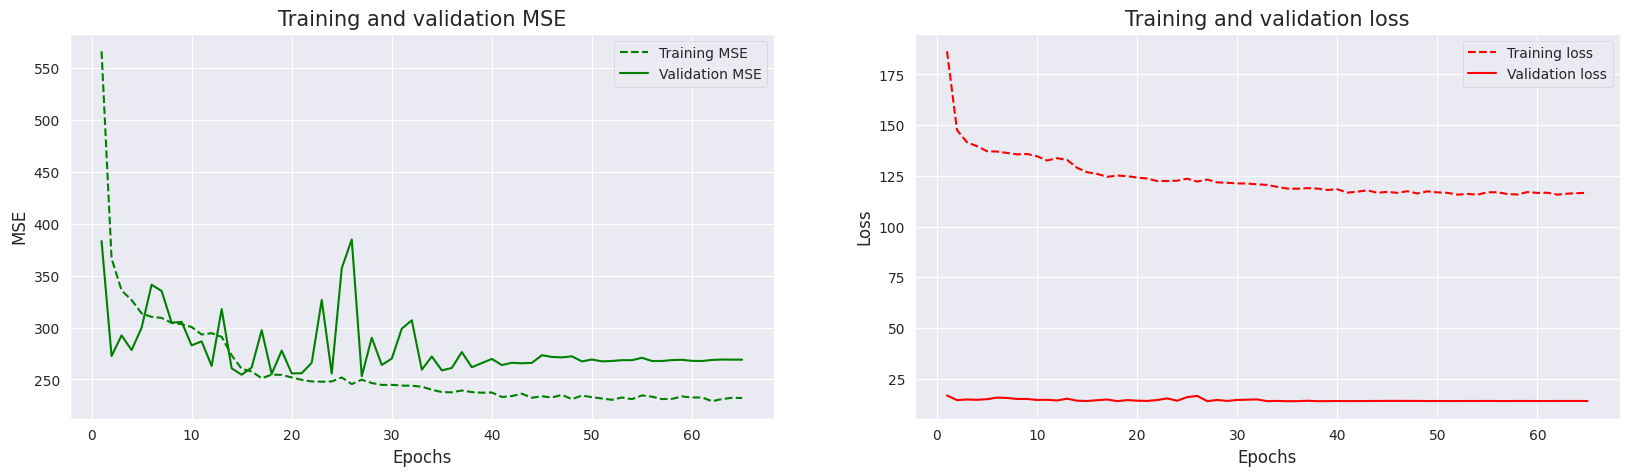

In [11]:
plot_learning_curves(history.history)

MAE: 14.798327137546469
MSE: 325.09200743494426
Spearman's Correlation: 0.18737223101065778
R Squared: 0.011398792266845703


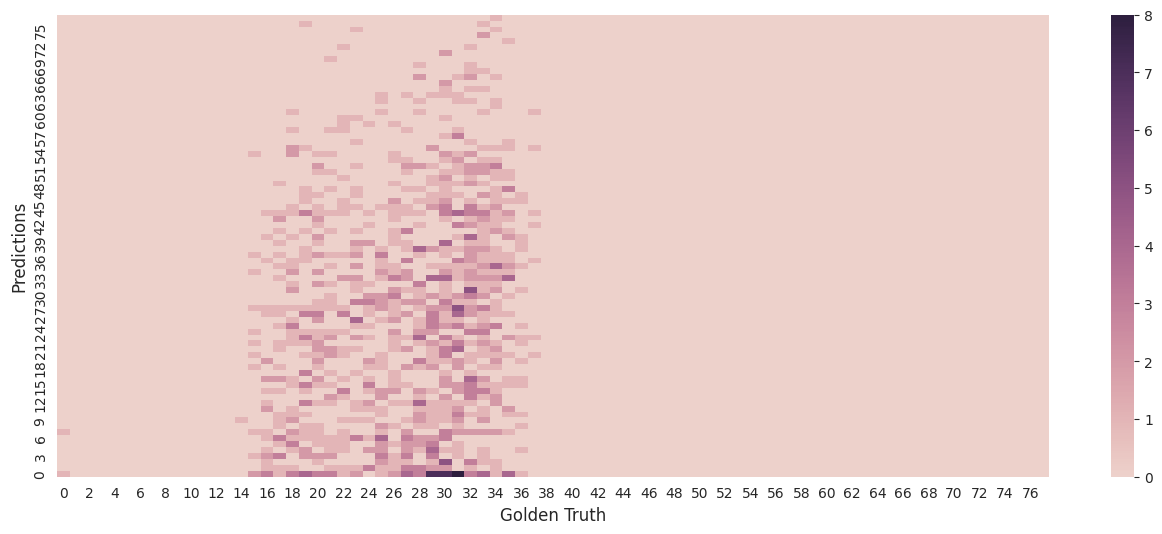

In [27]:
model.load_weights("conv1d_model.h5")
cnn_mae, cnn_mse, cnn_sp, cnn_r2 = report(model, X_mel_test)

In [12]:
model.load_weights("conv1d_model.h5")
print(model.evaluate(X_mel_test, y_test)) #326, 319 -- 323 with att 320

temp = pd.DataFrame(model.predict(X_mel_test).flatten().round(0).astype(int), index=X_audio_test.index)
true_ranks = y_test.argsort().argsort()
predicted_ranks = temp.iloc[:,0].argsort().argsort()

print(stats.spearmanr(true_ranks, predicted_ranks)) #0.1817

34/34 [==============================] - 0s 8ms/step - loss: 15.4958 - mse: 322.4454 - mae: 14.7501
[15.495786666870117, 322.4454345703125, 14.750143051147461]
SpearmanrResult(correlation=0.1895885543182712, pvalue=3.641329801109472e-10)


### Bi-GRU + Attention

In [10]:
def gru_model(d_model=256, n_layers=4):
    
    mel_input = Input(shape = (1292, 128), name="MEL_INPUT")
    
    x = Bidirectional(GRU(32, return_sequences=True))(mel_input)

    for i in range(n_layers - 1):
        x = Bidirectional(GRU(d_model, return_sequences=True))(x)
    
    def attention_rnn(inputs):
        # inputs.shape = (batch_size, time_steps, input_dim)
        input_dim = int(inputs.shape[2])
        timestep = int(inputs.shape[1])
        a = layers.Permute((2, 1))(inputs)  # Permutes the dimensions of the input according to a given pattern.
        a = layers.Dense(timestep, activation="softmax")(a)  # // Alignment Model + Softmax
        a = layers.Lambda(lambda x: keras.backend.mean(x, axis=1), name="dim_reduction")(a)
        a = layers.RepeatVector(input_dim)(a)
        a_probs = layers.Permute((2, 1), name="attention_vec")(a)
        output_attention_mul = layers.multiply([inputs, a_probs], name="attention_mul")  # // Weighted Average
        return output_attention_mul
    
    x = attention_rnn(x)
    #x = GlobalAvgPool1D()(x)
    #x = Flatten()(x)
    x = Dense(64, activation="selu", kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.2)(x)
    x = Dense(128, activation="selu", kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.2)(x)

    mel_out = Dense(1)(x)
    
    model = Model(inputs=mel_input, outputs=mel_out)

    model.compile(optimizer=Adam(learning_rate=1e-4, beta_1=0.99, beta_2=0.999), loss="logcosh", metrics=["mse", "mae"])

    model.summary()

    return model

In [11]:
keras.backend.clear_session()
model = gru_model()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 MEL_INPUT (InputLayer)         [(None, 1292, 128)]  0           []                               
                                                                                                  
 gru (GRU)                      (None, 1292, 32)     15552       ['MEL_INPUT[0][0]']              
                                                                                                  
 gru_1 (GRU)                    (None, 1292, 256)    222720      ['gru[0][0]']                    
                                                                                                  
 gru_2 (GRU)                    (None, 1292, 256)    394752      ['gru_1[0][0]']                  
                                                                                              

In [12]:
checkpoint = ModelCheckpoint(filepath='gru_model.h5', monitor="val_loss", save_best_only=True)
reduce_o_p = ReduceLROnPlateau(monitor="val_loss", patience=10, min_lr=1e-7, mode="min")
earlystopper = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=25)

history = model.fit(
        X_mel_train, y_train,
        sample_weight=sample_weight,
        validation_data=[X_mel_val, y_val],
        batch_size=16,
        epochs=40,
        callbacks=[checkpoint, reduce_o_p, earlystopper],
    )

2022-11-15 14:23:29.499640: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 5689595904 exceeds 10% of free system memory.
2022-11-15 14:23:32.693566: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 5689595904 exceeds 10% of free system memory.


Epoch 1/40


2022-11-15 14:23:38.226621: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8400
2022-11-15 14:23:38.404082: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


538/538 [==============================] - 77s 135ms/step - loss: 253.3875 - mse: 914.1556 - mae: 25.7872 - val_loss: 28.6893 - val_mse: 1016.3893 - val_mae: 27.6232 - lr: 1.0000e-05
Epoch 2/40
538/538 [==============================] - 72s 133ms/step - loss: 249.1663 - mse: 892.0300 - mae: 25.3732 - val_loss: 28.1459 - val_mse: 985.3560 - val_mae: 27.0703 - lr: 1.0000e-05
Epoch 3/40
538/538 [==============================] - 71s 133ms/step - loss: 242.3532 - mse: 855.7782 - mae: 24.6887 - val_loss: 27.3678 - val_mse: 938.2130 - val_mae: 26.2288 - lr: 1.0000e-05
Epoch 4/40
538/538 [==============================] - 72s 133ms/step - loss: 232.9125 - mse: 805.8070 - mae: 23.7368 - val_loss: 26.3635 - val_mse: 877.3184 - val_mae: 25.1255 - lr: 1.0000e-05
Epoch 5/40
538/538 [==============================] - 72s 134ms/step - loss: 221.3803 - mse: 745.2038 - mae: 22.5747 - val_loss: 25.1887 - val_mse: 806.6782 - val_mae: 23.8410 - lr: 1.0000e-05
Epoch 6/40
538/538 [=========================

KeyboardInterrupt: 

In [ ]:
plot_learning_curves(history.history)

In [ ]:
model.load_weights("gru_model.h5")
print(model.evaluate(X_mel_test, y_test)) #328

temp = pd.DataFrame(model.predict(X_mel_test).flatten().round(0).astype(int), index=X_audio_test.index)
true_ranks = y_test.argsort().argsort()
predicted_ranks = temp.iloc[:,0].argsort().argsort()

print(stats.spearmanr(true_ranks, predicted_ranks)) #0.72

### Conv1D + Bi-GRU + Attention

In [34]:
def conv1d_GRU_model(n_layers = 6, d_model=64):
    
    mel_input = Input(shape = (1292, 128), name="MEL_INPUT")
    
    #Spectrograms
    x = Conv1D(filters= 128, kernel_size= 11, padding='same', activation='relu')(mel_input)
    x = MaxPooling1D(pool_size=2)(x)
    x = BatchNormalization()(x)

    for i in range(n_layers - 1):
        x = Conv1D(32 * (2**i), kernel_size=11, strides=3 , padding='same', activation='relu')(x)
        x = MaxPooling1D(pool_size=4, padding='same')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.3)(x)

    #x = Dense(64, activation="selu", kernel_regularizer=l2(0.01))(x)
    #x = Dropout(0.2)(x)
    #x = Dense(128, activation="selu", kernel_regularizer=l2(0.01))(x)
    #x = Dropout(0.2)(x)
    
    print(x.shape)
    x = Bidirectional(GRU(32, return_sequences=True))(x)

    for i in range(n_layers - 1):
        x = Bidirectional(GRU(32, return_sequences=True))(x)

    def attention(inputs):
        # inputs.shape = (batch_size, time_steps, input_dim)
        input_dim = int(inputs.shape[2])
        timestep = int(inputs.shape[1])
        a = layers.Permute((2, 1))(inputs)  # Permutes the dimensions of the input according to a given pattern.
        a = layers.Dense(timestep, activation="softmax")(a)  # // Alignment Model + Softmax
        a = layers.Lambda(lambda x: keras.backend.mean(x, axis=1), name="dim_reduction")(a)
        a = layers.RepeatVector(input_dim)(a)
        a_probs = layers.Permute((2, 1), name="attention_vec")(a)
        output_attention_mul = layers.multiply([inputs, a_probs], name="attention_mul")  # // Weighted Average
        return output_attention_mul
    
    x = attention(x)
    mel_out = Dense(1, activation="relu", name="MEL_OUTPUT")(x)
    
    model = Model(inputs=mel_input, outputs=mel_out)

    # compile
    model.compile(optimizer=Adam(learning_rate=1e-4, beta_1=0.99, beta_2=0.999), loss="logcosh", metrics=["mse", "mae"])

    model.summary()
    return model

In [35]:
keras.backend.clear_session()
model = conv1d_GRU_model()

(None, 1, 512)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 MEL_INPUT (InputLayer)         [(None, 1292, 128)]  0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 1292, 128)    180352      ['MEL_INPUT[0][0]']              
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 646, 128)     0           ['conv1d[0][0]']                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 646, 128)    512         ['max_pooling1d[0][0]']          
 alization)                                                                    

                                                                                                  
 attention_mul (Multiply)       (None, 1, 64)        0           ['bidirectional_5[0][0]',        
                                                                  'attention_vec[0][0]']          
                                                                                                  
 MEL_OUTPUT (Dense)             (None, 1, 1)         65          ['attention_mul[0][0]']          
                                                                                                  
Total params: 2,344,739
Trainable params: 2,342,499
Non-trainable params: 2,240
__________________________________________________________________________________________________


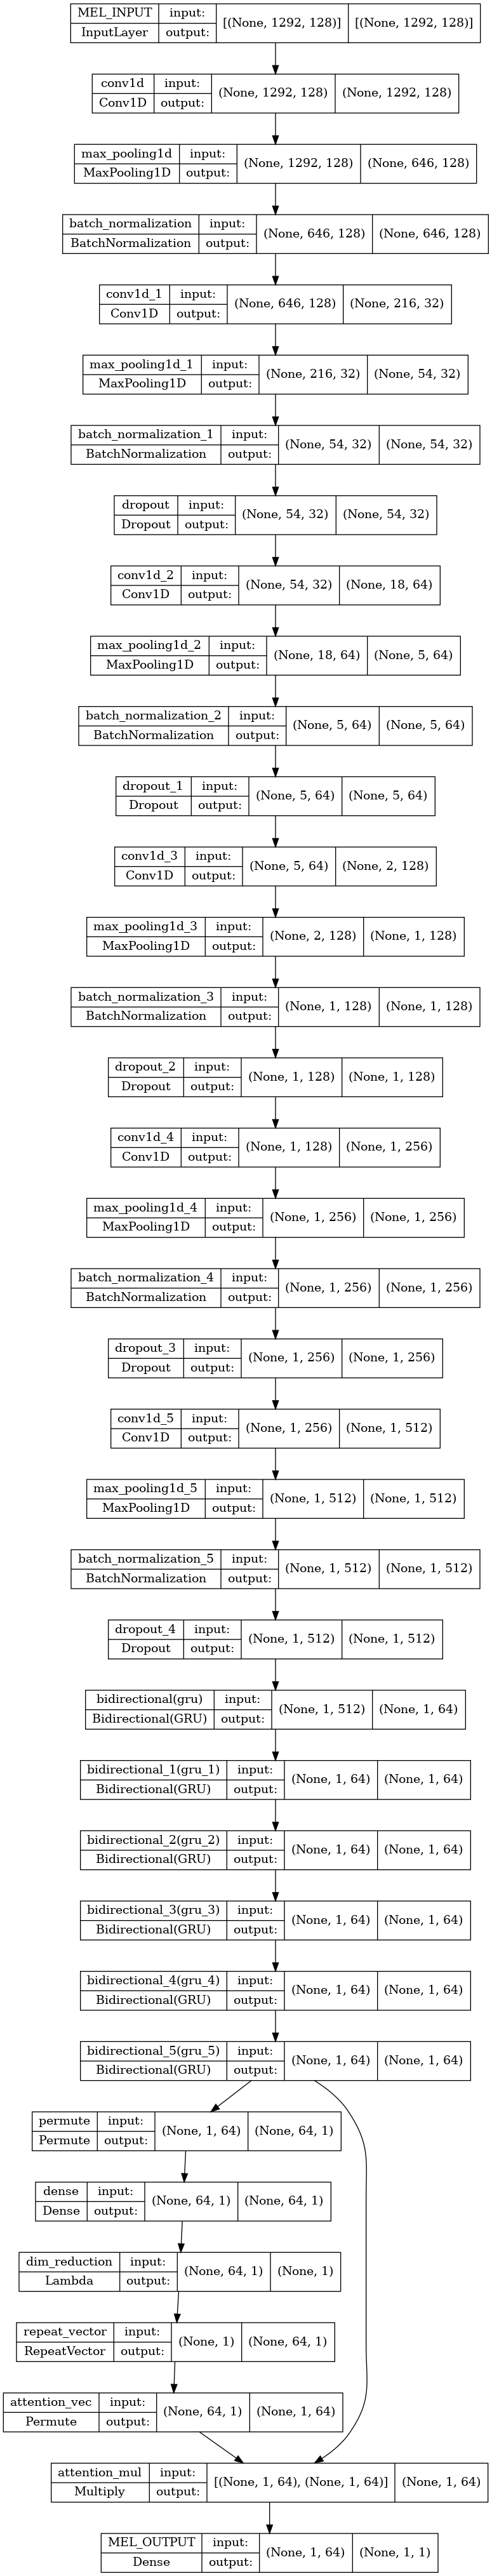

In [36]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [37]:
checkpoint = ModelCheckpoint(filepath='conv1d_GRU_model.h5', monitor="val_loss", save_best_only=True)
reduce_o_p = ReduceLROnPlateau(monitor="val_loss", patience=15, min_lr=1e-7, mode="min")
earlystopper = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=30)

history = model.fit(
        X_mel_train, y_train,
        sample_weight=sample_weight,
        validation_data=[X_mel_val, y_val],
        batch_size=16,
        epochs=100,
        callbacks=[checkpoint, reduce_o_p, earlystopper],
    )

Epoch 1/100
538/538 [==============================] - 22s 22ms/step - loss: 210.5181 - mse: 700.8743 - mae: 21.6860 - val_loss: 17.0037 - val_mse: 487.8141 - val_mae: 17.6805 - lr: 1.0000e-04
Epoch 2/100
538/538 [==============================] - 9s 17ms/step - loss: 145.3686 - mse: 368.2179 - mae: 15.1802 - val_loss: 14.7177 - val_mse: 374.5416 - val_mae: 15.3952 - lr: 1.0000e-04
Epoch 3/100
538/538 [==============================] - 9s 17ms/step - loss: 133.8382 - mse: 308.3038 - mae: 14.0276 - val_loss: 13.6883 - val_mse: 324.4504 - val_mae: 14.3621 - lr: 1.0000e-04
Epoch 4/100
538/538 [==============================] - 9s 17ms/step - loss: 128.4335 - mse: 278.7392 - mae: 13.4909 - val_loss: 13.1231 - val_mse: 295.5648 - val_mae: 13.8006 - lr: 1.0000e-04
Epoch 5/100
538/538 [==============================] - 9s 17ms/step - loss: 125.7375 - mse: 263.5565 - mae: 13.2198 - val_loss: 12.8236 - val_mse: 279.7050 - val_mae: 13.5006 - lr: 1.0000e-04
Epoch 6/100
538/538 [==================

538/538 [==============================] - 9s 17ms/step - loss: 114.3748 - mse: 228.0039 - mae: 12.0819 - val_loss: 12.4897 - val_mse: 269.0442 - val_mae: 13.1598 - lr: 1.0000e-05
Epoch 86/100
538/538 [==============================] - 9s 17ms/step - loss: 114.4141 - mse: 227.7649 - mae: 12.0859 - val_loss: 12.4141 - val_mse: 261.9187 - val_mae: 13.0840 - lr: 1.0000e-05
Epoch 87/100
538/538 [==============================] - 9s 17ms/step - loss: 113.8664 - mse: 226.5999 - mae: 12.0294 - val_loss: 12.5084 - val_mse: 269.3083 - val_mae: 13.1777 - lr: 1.0000e-05
Epoch 88/100
538/538 [==============================] - 9s 17ms/step - loss: 114.3997 - mse: 228.7903 - mae: 12.0837 - val_loss: 12.3289 - val_mse: 253.8252 - val_mae: 12.9983 - lr: 1.0000e-05
Epoch 89/100
538/538 [==============================] - 9s 17ms/step - loss: 114.0439 - mse: 227.0828 - mae: 12.0495 - val_loss: 12.5250 - val_mse: 270.6326 - val_mae: 13.1965 - lr: 1.0000e-05
Epoch 90/100
538/538 [==========================

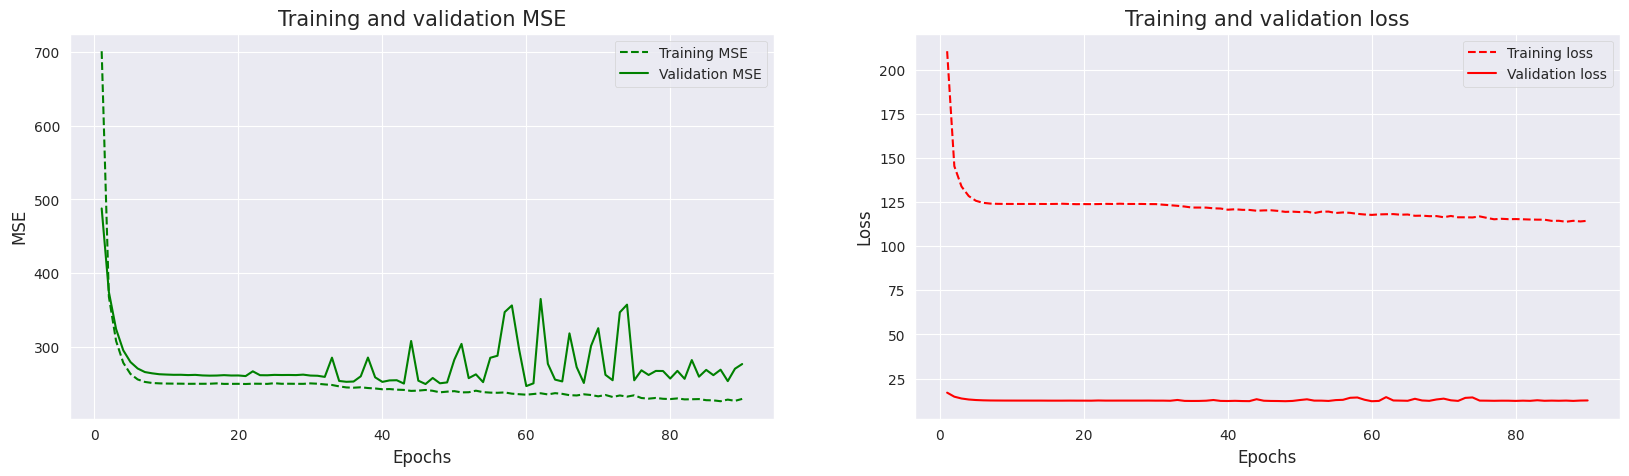

In [38]:
plot_learning_curves(history.history)

MAE: 14.803903345724907
MSE: 323.88197026022306
Spearman's Correlation: 0.1845324936250061
R Squared: 0.015078485012054443


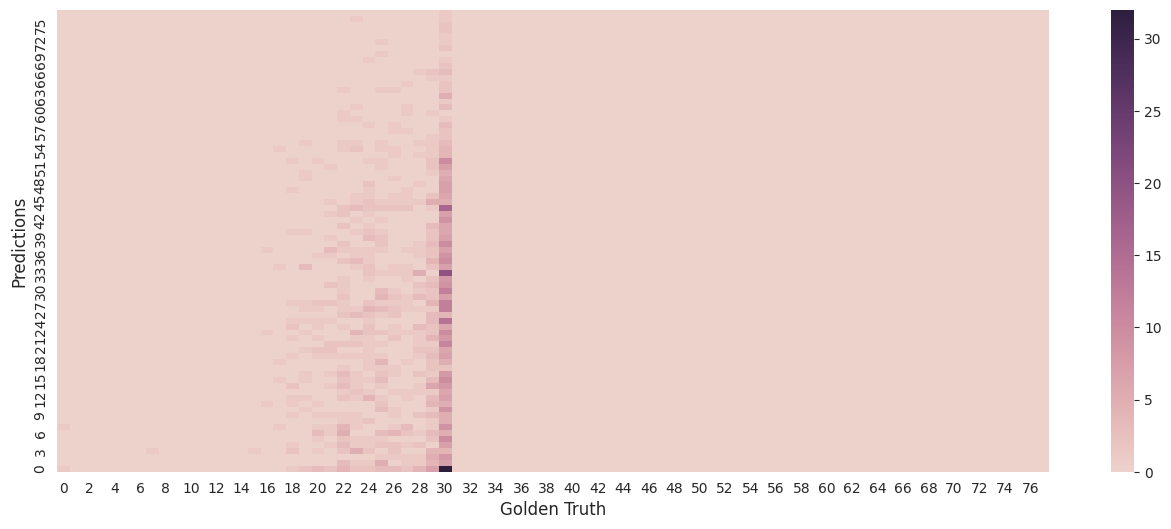

In [39]:
model.load_weights("conv1d_GRU_model.h5")
cnn_mae, cnn_mse, cnn_sp, cnn_r2 = report(model, X_mel_test)

## Final Model - Before Song Release 

In [8]:
def before_model(d_model=64, n_layers=6, max_len=6, vocab_len=171, n_timesteps = 41, n_features = 2):
    
    mel_input = Input(shape = (1292, 128), name="MEL_INPUT")
    audio_input = Input(shape= (X_audio_train.shape[1:]), name="AUDIO_INPUT")
    genres_input = Input(shape=(X_genres_train.shape[1:]), name="GENRES_INPUT")
    
    #Spectrograms
    x = Conv1D(filters= 128, kernel_size= 11, padding='same', activation='relu')(mel_input)
    x = MaxPooling1D(pool_size=2)(x)
    x = BatchNormalization()(x)

    for i in range(n_layers - 1):
        x = Conv1D(32 * (2**i), kernel_size=11, strides=3 , padding='same', activation='relu')(x)
        x = MaxPooling1D(pool_size=4, padding='same')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.3)(x)

    x = GlobalAvgPool1D()(x)
    #x = Flatten()(x)
    x = Dense(64, activation="selu", kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.2)(x)
    x = Dense(64, activation="selu", kernel_regularizer=l2(0.01))(x)
    mel_out = Dropout(0.3)(x)
    
    hidden_layer = Dense(256, activation = 'swish')(audio_input)
    hidden_layer = Dense(32, activation = 'swish')(hidden_layer)
    dropout = Dropout(0.4)(hidden_layer)
    hidden_layer = Dense(32, activation = 'swish')(dropout)
    dropout = Dropout(0.4)(hidden_layer)
    hidden_layer = Dense(32, activation = 'swish')(dropout)
    y = Dropout(0.4)(hidden_layer)
    
    hidden_layer = Dense(32, activation = 'swish')(genres_input)
    hidden_layer = Dense(176, activation = 'swish')(hidden_layer)
    dropout = Dropout(0.6)(hidden_layer)
    hidden_layer = Dense(32, activation = 'swish')(dropout)
    dropout = Dropout(0.6)(hidden_layer)
    hidden_layer = Dense(96, activation = 'selu')(dropout)
    dropout = Dropout(0.6)(hidden_layer)
    hidden_layer = Dense(256, activation = 'relu')(dropout)
    e = Dropout(0.6)(hidden_layer)
    
    audio_genres_out = Concatenate(axis=1, name="AUDIO_GENRE_OUTPUT")([y, e])
    
    #Combined inputs are passed through a final MLP network
    combined = Concatenate(axis=1)([mel_out, audio_genres_out])

    out = Dense(1)(combined)

    model = Model(inputs=[mel_input, audio_input, genres_input], outputs=out)

    model.compile(optimizer=Adam(learning_rate=1e-4, beta_1=0.99, beta_2=0.999), loss="logcosh", metrics=["mse", "mae"])

    model.summary()

    return model

In [9]:
keras.backend.clear_session()
model = before_model()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 MEL_INPUT (InputLayer)         [(None, 1292, 128)]  0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 1292, 128)    180352      ['MEL_INPUT[0][0]']              
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 646, 128)     0           ['conv1d[0][0]']                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 646, 128)    512         ['max_pooling1d[0][0]']          
 alization)                                                                                   

                                                                                                  
 dense (Dense)                  (None, 64)           32832       ['global_average_pooling1d[0][0]'
                                                                 ]                                
                                                                                                  
 dropout_8 (Dropout)            (None, 32)           0           ['dense_4[0][0]']                
                                                                                                  
 dropout_12 (Dropout)           (None, 96)           0           ['dense_9[0][0]']                
                                                                                                  
 dropout_5 (Dropout)            (None, 64)           0           ['dense[0][0]']                  
                                                                                                  
 dense_5 (

2022-11-15 17:55:30.522647: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-15 17:55:30.523636: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-15 17:55:30.523834: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-15 17:55:30.523975: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

 dropout_9 (Dropout)            (None, 32)           0           ['dense_5[0][0]']                
                                                                                                  
 dropout_13 (Dropout)           (None, 256)          0           ['dense_10[0][0]']               
                                                                                                  
 dropout_6 (Dropout)            (None, 64)           0           ['dense_1[0][0]']                
                                                                                                  
 AUDIO_GENRE_OUTPUT (Concatenat  (None, 288)         0           ['dropout_9[0][0]',              
 e)                                                               'dropout_13[0][0]']             
                                                                                                  
 concatenate (Concatenate)      (None, 352)          0           ['dropout_6[0][0]',              
          

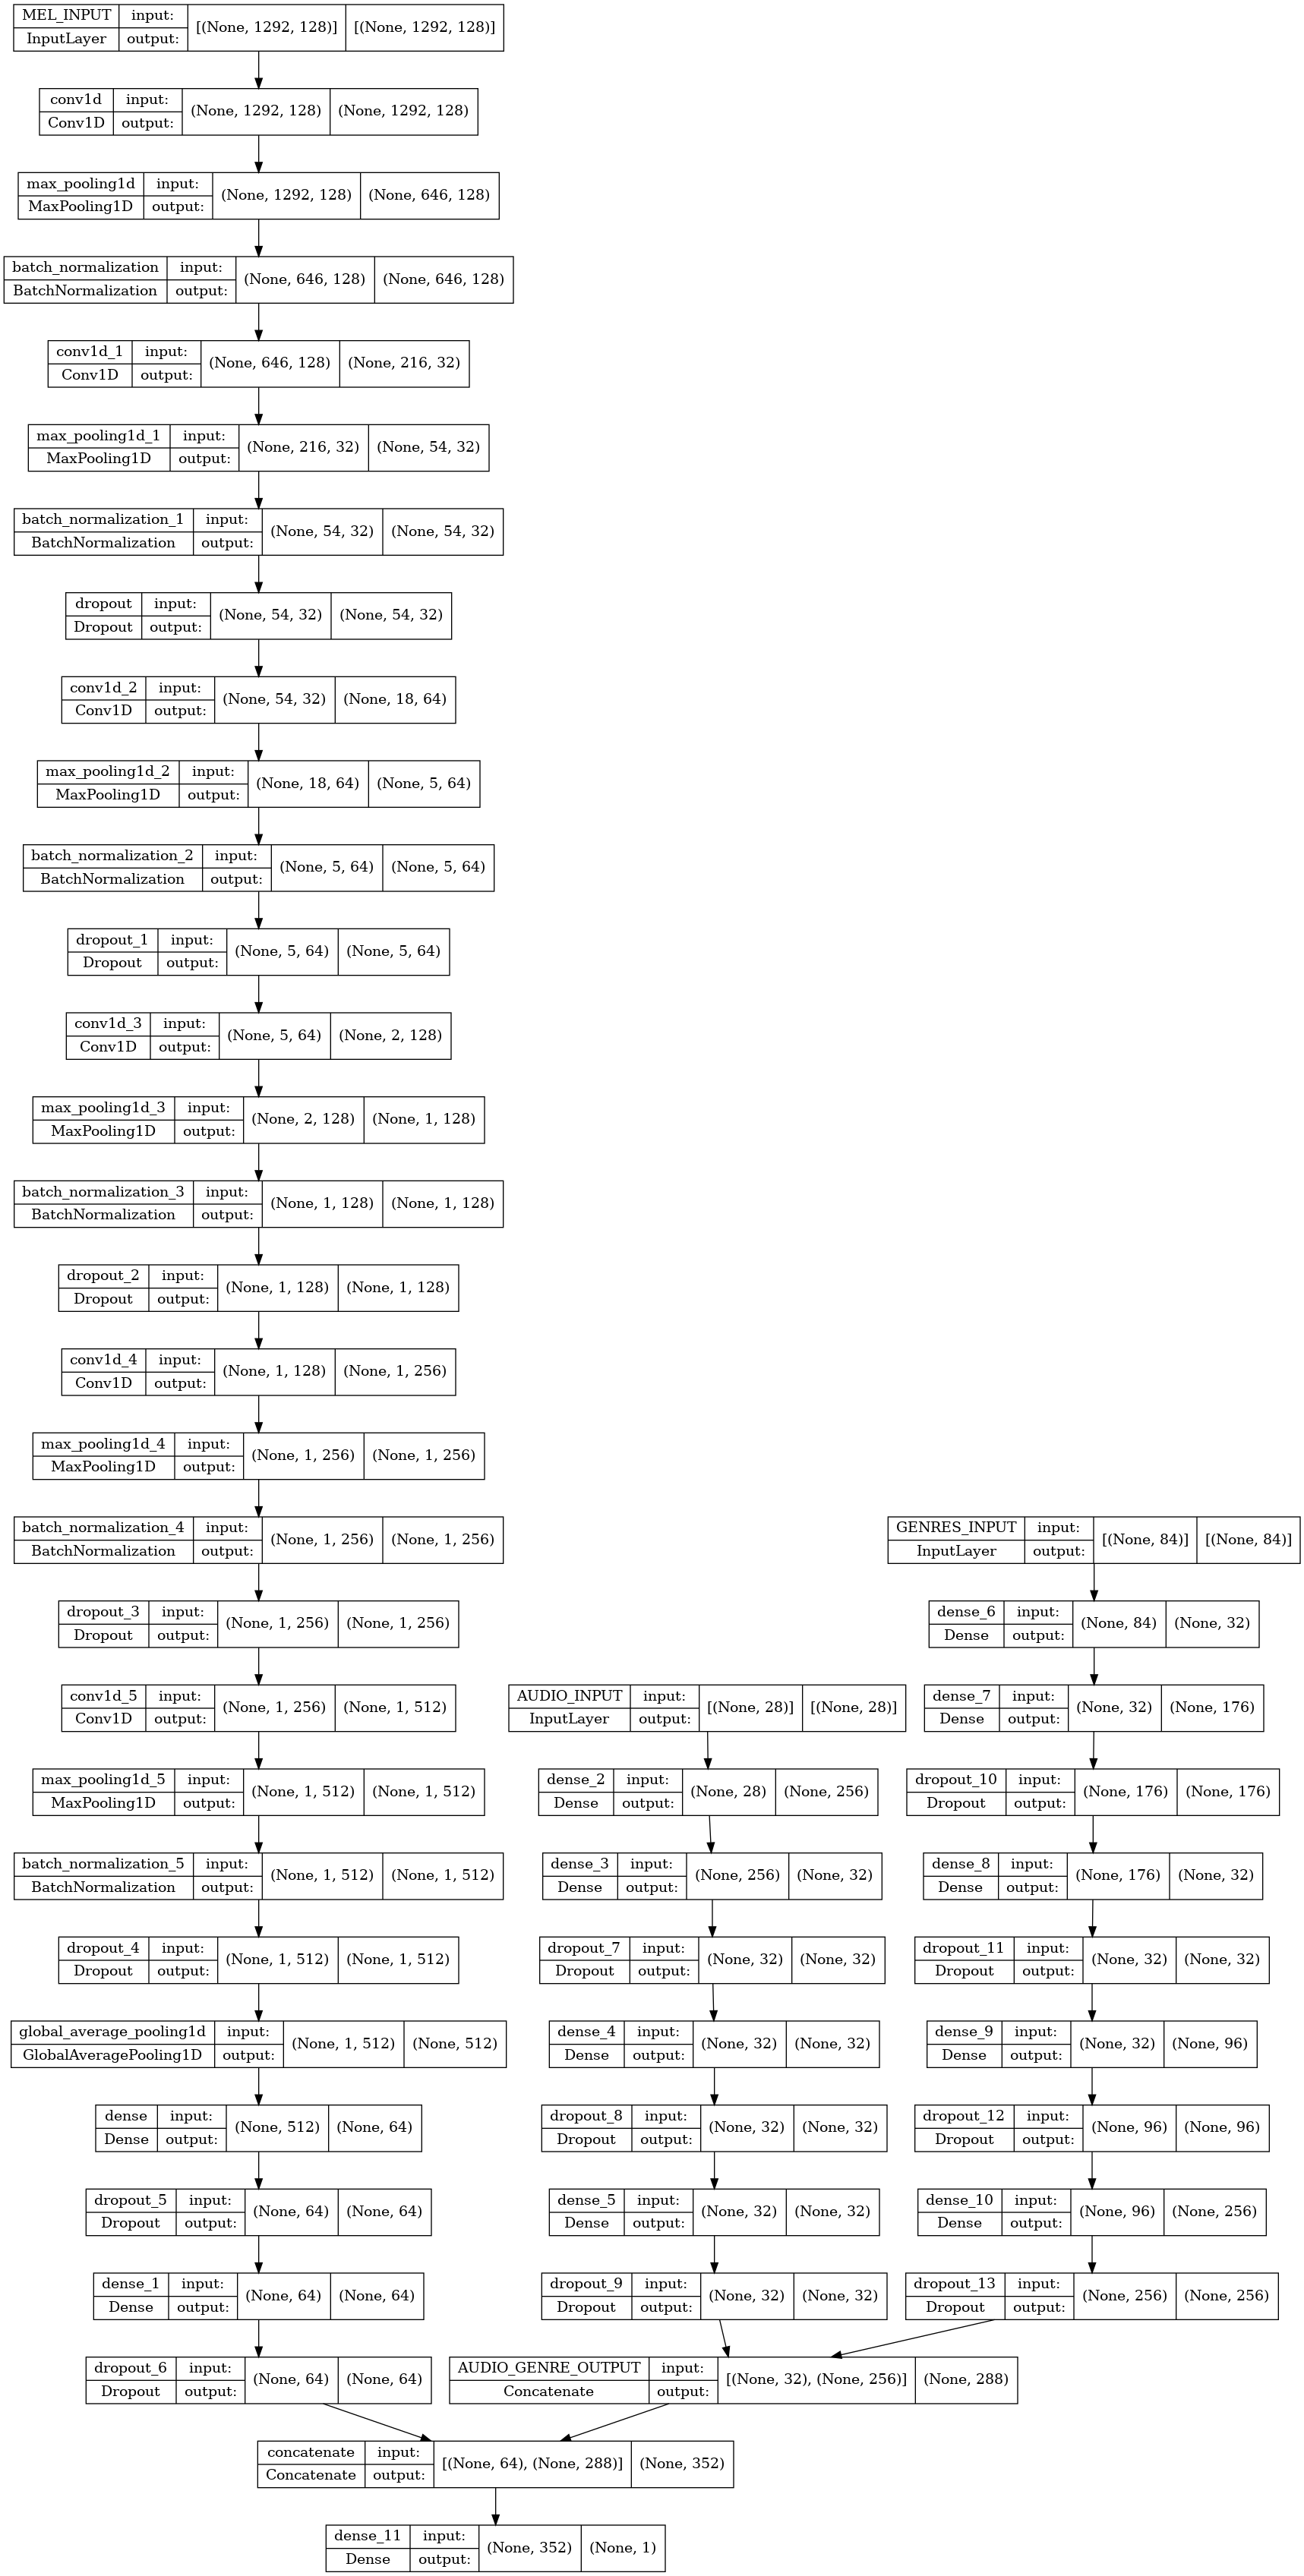

In [10]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [11]:
checkpoint = ModelCheckpoint(filepath='before_model.h5', monitor="val_mae", save_best_only=True)
reduce_o_p = ReduceLROnPlateau(monitor="val_mae", patience=15, min_lr=1e-7, mode="min")
earlystopper = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=30)

history = model.fit(
        [X_mel_train, X_audio_train, X_genres_train], y_train,
        sample_weight=sample_weight,
        validation_data=[[X_mel_val, X_audio_val, X_genres_val], y_val],
        batch_size=16,
        epochs=100,
        callbacks=[checkpoint, reduce_o_p, earlystopper],
    )

2022-11-15 17:55:36.362973: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 5689595904 exceeds 10% of free system memory.
2022-11-15 17:55:39.634332: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 5689595904 exceeds 10% of free system memory.


Epoch 1/100


2022-11-15 17:55:43.589380: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-11-15 17:55:43.693331: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8400


538/538 [==============================] - 10s 12ms/step - loss: 188.1475 - mse: 569.1487 - mae: 19.2744 - val_loss: 14.2835 - val_mse: 259.9944 - val_mae: 13.1213 - lr: 1.0000e-04
Epoch 2/100
538/538 [==============================] - 6s 11ms/step - loss: 128.8280 - mse: 268.0945 - mae: 13.3475 - val_loss: 14.0501 - val_mse: 251.3035 - val_mae: 12.9108 - lr: 1.0000e-04
Epoch 3/100
538/538 [==============================] - 6s 11ms/step - loss: 127.1160 - mse: 260.4641 - mae: 13.1788 - val_loss: 13.9875 - val_mse: 247.4124 - val_mae: 12.8665 - lr: 1.0000e-04
Epoch 4/100
538/538 [==============================] - 6s 11ms/step - loss: 125.2333 - mse: 254.6287 - mae: 12.9931 - val_loss: 14.0967 - val_mse: 259.1648 - val_mae: 12.9873 - lr: 1.0000e-04
Epoch 5/100
538/538 [==============================] - 6s 11ms/step - loss: 124.4081 - mse: 253.5127 - mae: 12.9092 - val_loss: 14.3176 - val_mse: 271.7150 - val_mae: 13.2205 - lr: 1.0000e-04
Epoch 6/100
538/538 [==============================

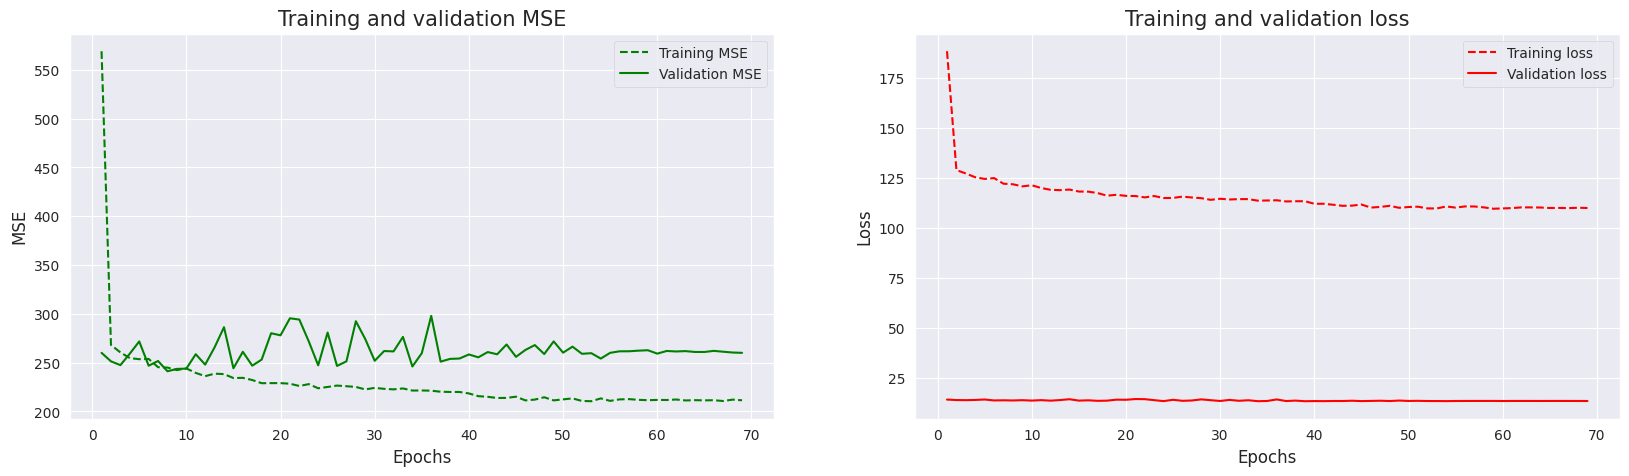

In [12]:
plot_learning_curves(history.history)

MAE: 13.680297397769516
MSE: 284.2843866171004
Spearman's Correlation: 0.36552816544424593
R Squared: 0.13549429178237915


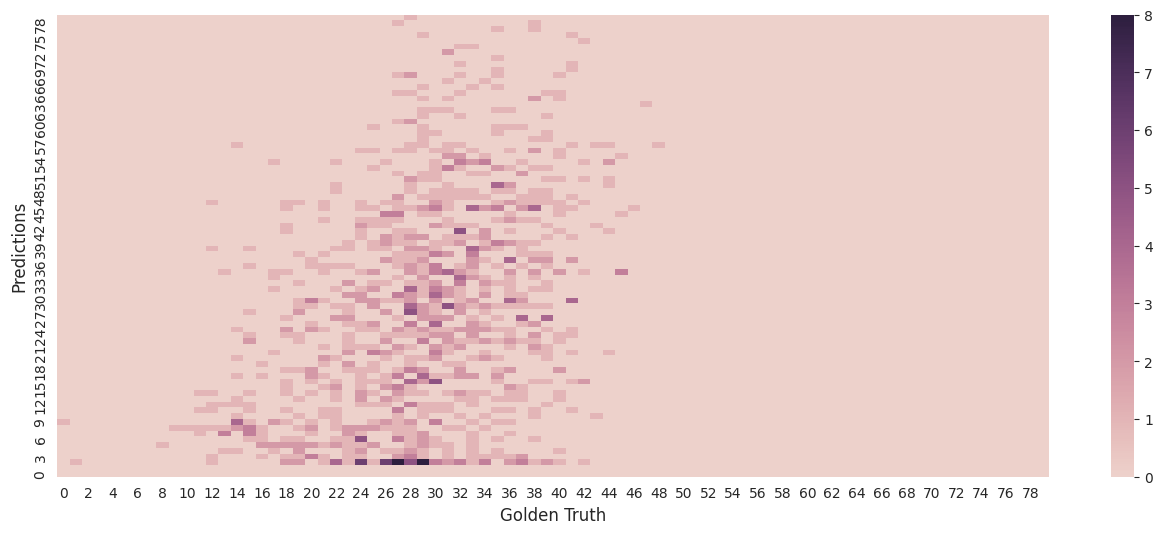

In [14]:
model.load_weights("before_model.h5")
cnn_mae, cnn_mse, cnn_sp, cnn_r2 = report(model,[X_mel_test, X_audio_test, X_genre_test])

## Time Series Input

For example, if you have 5 sentences, each sentence contains 10 words (or you pad them such that they are equally of length 10), and your single LSTM layer has 15 units, your outputs would be of shape (5, 15) if you do not return sequence. In case you do, you will get output shape (5, 10, 15).

### Conv1d

In [60]:
def build_rnn_model(hp):

    #tuning the number of the rnn layers
    conv_layers = hp.Int('conv_layers', 1, 6)
    mlp_layers = hp.Int('mlp_layers', 1, 3)
    #tuning the dropout percentage of the dropout layers
    dropout_c = hp.Float('dropout_c', min_value=0.1, max_value=0.4, step=0.1)
    dropout_d = hp.Float('dropout_d', min_value=0.1, max_value=0.4, step=0.1)
    
    n_timesteps = 41
    n_features = 2
    
    views_input = Input(shape=(n_timesteps, n_features), name="TIMESERIES_INPUT")
    x = Conv1D(filters=hp.Int(f'filters{0}', min_value=32, max_value=512, step = 32),
                    kernel_size=hp.Int(f'kernel_size{0}', min_value=3, max_value=11, step = 2),
                    padding='same',activation='relu')(views_input)
    x = MaxPooling1D(pool_size=2)(x)
    x = BatchNormalization()(x)

    for i in range(conv_layers):
        x = Conv1D(filters=hp.Int(f'filters{i}', min_value=32, max_value=512, step = 32),
                    kernel_size=hp.Int(f'kernel_size{i}', min_value=3, max_value=11, step = 2),
                    padding='same',activation='relu')(x)
        x = MaxPooling1D(pool_size=2, padding = 'same')(x)
        x = BatchNormalization()(x)
        x = Dropout(dropout_c)(x)
        
    x = GlobalAvgPool1D()(x)
    
    x = Dense(units=hp.Int(f"hidden{1}", min_value=32, max_value=128, step=32),
              activation=hp.Choice(f"dense_activation_{1}", values=["relu", "elu"]))(x)
    
    for i in range(mlp_layers):
        x = Dense(units=hp.Int(f"hidden_{i}", min_value=32, max_value=128, step=32),
                  activation=hp.Choice(f"dense_activation_{i}", values=["relu", "elu"]),)(x)
        x = Dropout(dropout_d)(x)
    
    output = Dense(1)(x)
    model = Model(inputs=views_input, outputs=output)

    # compile
    model.compile(optimizer=Adam(learning_rate=1e-4, beta_1=0.99, beta_2=0.999), loss="logcosh", metrics=["mse", "mae"])
                      
    model.summary()
    return model

In [61]:
#Creating the Bayesian optimization tuner
keras.backend.clear_session()
rnn_tuner = kt.BayesianOptimization(build_rnn_model,
                                    objective='val_loss',
                                    max_trials=20,
                                    directory='rnn1_dir')

rnn_tuner.search_space_summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 TIMESERIES_INPUT (InputLaye  [(None, 41, 2)]          0         
 r)                                                              
                                                                 
 conv1d (Conv1D)             (None, 41, 32)            224       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 20, 32)           0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 20, 32)           128       
 ormalization)                                                   
                                                                 
 conv1d_1 (Conv1D)           (None, 20, 32)            3104      
                                                             

In [62]:
#Creating an early stopping callback
reduce_o_p = ReduceLROnPlateau(monitor="val_loss", patience=10, min_lr=1e-7, mode="min")
earlystopper = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=20)

#Searching for the best hyperparameters of the mlp model
#with tf.device('/CPU:0'):
rnn_tuner.search(X_views_train,y_train,
                epochs=40,
                validation_data=(X_views_val,y_val),
                verbose=1,
                callbacks=[reduce_o_p, earlystopper])

In [63]:
#Retrieving the best hyperparameter
best_rnn_hp = rnn_tuner.get_best_hyperparameters()[0]
print(best_rnn_hp.values)

#Building the optimal mlp model using the best hyperparameters the tuner gave us
best_rnn_model = rnn_tuner.hypermodel.build(best_rnn_hp)

{'conv_layers': 1, 'mlp_layers': 2, 'dropout_c': 0.30000000000000004, 'dropout_d': 0.30000000000000004, 'filters0': 384, 'kernel_size0': 3, 'hidden1': 32, 'dense_activation_1': 'relu', 'hidden_0': 64, 'dense_activation_0': 'elu', 'filters1': 256, 'kernel_size1': 3, 'filters2': 512, 'kernel_size2': 11, 'hidden_1': 128}
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 TIMESERIES_INPUT (InputLaye  [(None, 41, 2)]          0         
 r)                                                              
                                                                 
 conv1d_2 (Conv1D)           (None, 41, 384)           2688      
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 20, 384)          0         
 1D)                                                             
                                                                 
 ba

In [64]:
checkpoint = ModelCheckpoint(filepath='rnn1_model.h5', monitor="val_loss", save_best_only=True)
reduce_o_p = ReduceLROnPlateau(monitor="val_loss", patience=30, min_lr=1e-7, mode="min")
earlystopper = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=50)

keras.backend.clear_session()
#Training the optimal mlp model for 30 epochs 
best_rnn_history = best_rnn_model.fit(X_views_train,y_train,
                                      sample_weight=sample_weight,
                                      validation_data=(X_views_val,y_val),
                                      epochs=200,
                                      batch_size=16,
                                      callbacks=[checkpoint, reduce_o_p, earlystopper])

Epoch 1/200
538/538 [==============================] - 2s 3ms/step - loss: 135.9227 - mse: 332.7186 - mae: 14.2421 - val_loss: 9.9967 - val_mse: 178.5939 - val_mae: 10.6684 - lr: 1.0000e-04
Epoch 2/200
538/538 [==============================] - 2s 3ms/step - loss: 91.5762 - mse: 155.8365 - mae: 9.8066 - val_loss: 8.0610 - val_mse: 117.5251 - val_mae: 8.7248 - lr: 1.0000e-04
Epoch 3/200
538/538 [==============================] - 2s 3ms/step - loss: 88.2393 - mse: 144.2321 - mae: 9.4733 - val_loss: 7.4723 - val_mse: 106.1657 - val_mae: 8.1321 - lr: 1.0000e-04
Epoch 4/200
538/538 [==============================] - 2s 3ms/step - loss: 85.6311 - mse: 138.7592 - mae: 9.2146 - val_loss: 7.3058 - val_mse: 104.5890 - val_mae: 7.9667 - lr: 1.0000e-04
Epoch 5/200
538/538 [==============================] - 2s 3ms/step - loss: 84.5140 - mse: 136.4619 - mae: 9.1020 - val_loss: 8.9890 - val_mse: 154.0280 - val_mae: 9.6565 - lr: 1.0000e-04
Epoch 6/200
538/538 [==============================] - 2s 3ms/

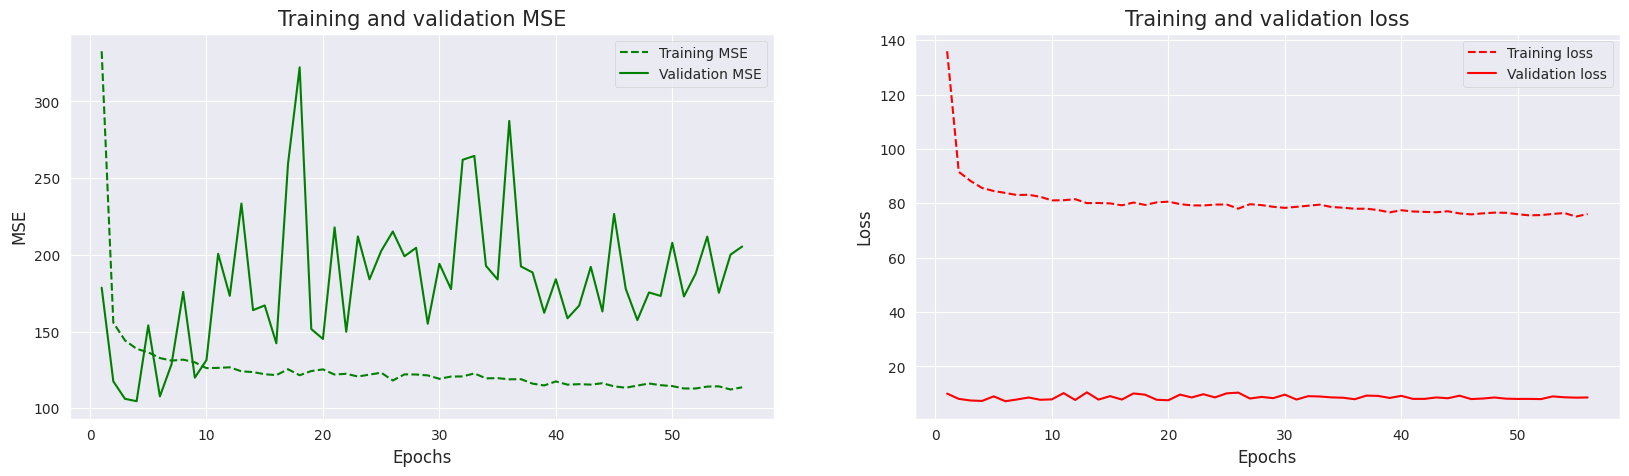

In [65]:
plot_learning_curves(best_rnn_history.history)

MAE: 10.899628252788103
MSE: 244.25650557620818
Spearman's Correlation: 0.6636728008047098
R Squared: 0.2572186589241028


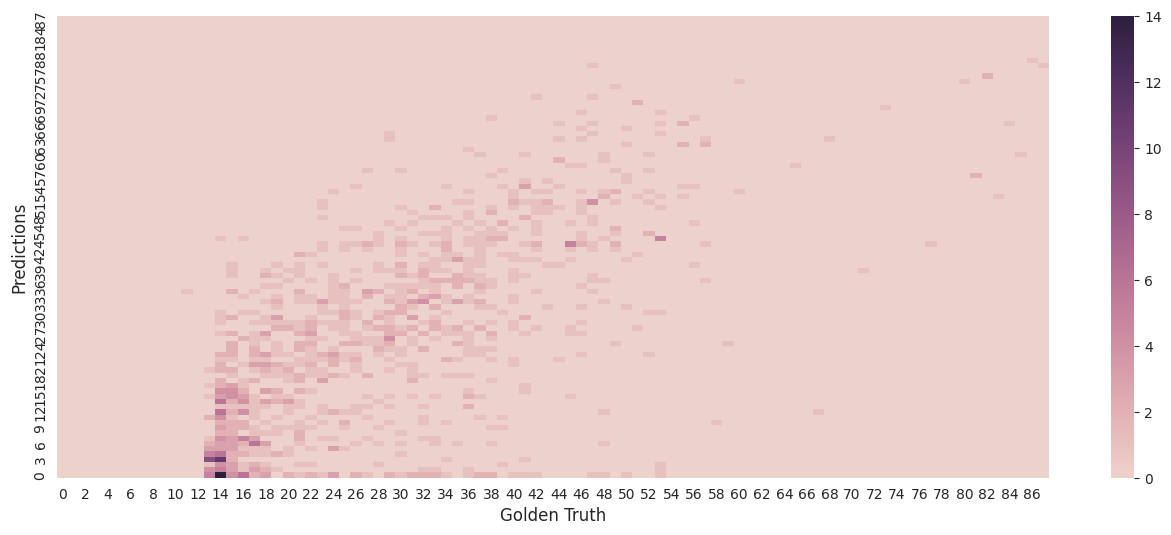

In [66]:
best_rnn_model.load_weights("rnn1_model.h5")
rnn_mae, rnn_mse, rnn_sp, rnn_r2 = report(best_rnn_model, X_views_test)

In [15]:
best_rnn_model.load_weights("rnn1_model.h5")
print(best_rnn_model.evaluate(X_views_test, y_test)) #328

temp = pd.DataFrame(best_rnn_model.predict(X_views_test).flatten().round(0).astype(int), index=X_audio_test.index)
true_ranks = y_test.argsort().argsort()
predicted_ranks = temp.iloc[:,0].argsort().argsort()

print(stats.spearmanr(true_ranks, predicted_ranks)) #0.72

34/34 [==============================] - 0s 4ms/step - loss: 11.1439 - mse: 573.0139 - mae: 11.8120
[11.143942832946777, 573.0138549804688, 11.812029838562012]
34/34 [==============================] - 0s 1ms/step
SpearmanrResult(correlation=0.684430488906463, pvalue=1.4787572245113555e-149)


### Bi - GRU 

In [8]:
def build_rnn2_model(hp):

    #tuning the number of the rnn layers
    rnn_layers = hp.Int('rnn_layers', 1, 5)
    mlp_layers = hp.Int('mlp_layers', 1, 3)
    #tuning the dropout percentage of the dropout layers
    dropout_r = hp.Float('dropout_r', min_value=0.1, max_value=0.4, step=0.1)
    dropout_d = hp.Float('dropout_d', min_value=0.1, max_value=0.4, step=0.1)
    
    n_timesteps = 41
    n_features = 2
    
    views_input = Input(shape=(n_timesteps, n_features), name="TIMESERIES_INPUT")
    bi_gru = Bidirectional(GRU(hp.Int('input_unit',min_value=32,max_value=128,step=32), return_sequences=True))(views_input)

    for i in range(rnn_layers):
        bi_gru = Bidirectional(GRU(hp.Int(f'gru_{i}_units',min_value=32,max_value=128,step=32), return_sequences=True))(bi_gru)
        
    dropout = Dropout(dropout_r)(bi_gru)
    x = GlobalAvgPool1D()(dropout)

    flatten = Flatten()(x)
    
    x = Dense(units=hp.Int(f"hidden{1}", min_value=32, max_value=128, step=32),
              activation=hp.Choice(f"dense_activation_{1}", values=["relu", "elu"]))(flatten)
    
    for i in range(mlp_layers):
        x = Dense(units=hp.Int(f"hidden_{i}", min_value=32, max_value=128, step=32),
                  activation=hp.Choice(f"dense_activation_{i}", values=["relu", "elu"]),)(x)
        dropout = Dropout(dropout_d)(x)
    
    output = Dense(1)(x)
    model = Model(inputs=views_input, outputs=output)

    # compile
    model.compile(optimizer=Adam(learning_rate=1e-4, beta_1=0.99, beta_2=0.999), loss="logcosh", metrics=["mse", "mae"])
                      
    model.summary()
    return model

{'rnn_layers': 1, 'mlp_layers': 3, 'dropout_r': 0.1, 'dropout_d': 0.1, 'input_unit': 32, 'gru_0_units': 32, 'hidden1': 128, 'dense_activation_1': 'relu', 'hidden_0': 32, 'dense_activation_0': 'elu', 'hidden_1': 32, 'hidden_2': 128, 'dense_activation_2': 'relu', 'gru_1_units': 128, 'gru_2_units': 128, 'gru_3_units': 128, 'gru_4_units': 32}

In [ ]:
def build_rnn2_model(hp):

    bi_gru = Bidirectional(GRU(32, return_sequences=True))(views_input)
    bi_gru = Bidirectional(GRU(32, return_sequences=True))(bi_gru)

    dropout = Dropout(0.1)(bi_gru)
    
    x = GlobalAvgPool1D()(dropout)
    flatten = Flatten()(x)
    
    x = Dense(128, activation='relu')(flatten)
    x = Dense(32, activation='elu')(x)
    dropout = Dropout(0.1)(x)
    x = Dense(32, activation='relu')(x)
    dropout = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    dropout = Dropout(0.1)(x)
    
    output = Dense(1)(x)
    model = Model(inputs=views_input, outputs=output)

    # compile
    model.compile(optimizer=Adam(learning_rate=1e-4, beta_1=0.99, beta_2=0.999), loss="logcosh", metrics=["mse", "mae"])
                      
    model.summary()
    return model

In [10]:
#Creating the Bayesian optimization tuner
keras.backend.clear_session()
rnn_tuner = kt.BayesianOptimization(build_rnn2_model,
                                    objective='val_loss',
                                    max_trials=25,
                                    directory='rnn_2_dir_')

rnn_tuner.search_space_summary()

2022-11-15 18:29:11.176024: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-15 18:29:11.177071: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-15 18:29:11.177269: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-15 18:29:11.177409: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 TIMESERIES_INPUT (InputLaye  [(None, 41, 2)]          0         
 r)                                                              
                                                                 
 bidirectional (Bidirectiona  (None, 41, 64)           6912      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 41, 64)           18816     
 nal)                                                            
                                                                 
 dropout (Dropout)           (None, 41, 64)            0         
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                      

In [11]:
#Creating an early stopping callback
reduce_o_p = ReduceLROnPlateau(monitor="val_loss", patience=10, min_lr=1e-7, mode="min")
earlystopper = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=20)

#Searching for the best hyperparameters of the mlp model
#with tf.device('/CPU:0'):
rnn_tuner.search(X_views_train,y_train,
                epochs=40,
                validation_data=(X_views_val,y_val),
                verbose=1,
                callbacks=[reduce_o_p, earlystopper])

Trial 25 Complete [00h 01m 13s]
val_loss: 7.3516740798950195

Best val_loss So Far: 7.126585960388184
Total elapsed time: 00h 33m 45s


In [12]:
#Retrieving the best hyperparameter
best_rnn2_hp = rnn_tuner.get_best_hyperparameters()[0]
print(best_rnn2_hp.values)

#Building the optimal mlp model using the best hyperparameters the tuner gave us
best_rnn2_model = rnn_tuner.hypermodel.build(best_rnn2_hp)

{'rnn_layers': 1, 'mlp_layers': 3, 'dropout_r': 0.1, 'dropout_d': 0.1, 'input_unit': 32, 'gru_0_units': 32, 'hidden1': 128, 'dense_activation_1': 'relu', 'hidden_0': 32, 'dense_activation_0': 'elu', 'hidden_1': 32, 'hidden_2': 128, 'dense_activation_2': 'relu', 'gru_1_units': 128, 'gru_2_units': 128, 'gru_3_units': 128, 'gru_4_units': 32}
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 TIMESERIES_INPUT (InputLaye  [(None, 41, 2)]          0         
 r)                                                              
                                                                 
 bidirectional_2 (Bidirectio  (None, 41, 64)           6912      
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 41, 64)           18816     
 nal)                                           

In [13]:
checkpoint = ModelCheckpoint(filepath='rnn2_model.h5', monitor="val_loss", save_best_only=True)
reduce_o_p = ReduceLROnPlateau(monitor="val_loss", patience=30, min_lr=1e-7, mode="min")
earlystopper = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=50)

keras.backend.clear_session()
#Training the optimal mlp model for 30 epochs 
best_rnn_history = best_rnn2_model.fit(X_views_train,y_train,
                                      sample_weight=sample_weight,
                                      validation_data=(X_views_val,y_val),
                                      epochs=200,
                                      batch_size=16,
                                      callbacks=[checkpoint, reduce_o_p, earlystopper])

Epoch 1/200
538/538 [==============================] - 7s 8ms/step - loss: 189.1798 - mse: 598.1771 - mae: 19.5541 - val_loss: 13.9821 - val_mse: 361.8382 - val_mae: 14.6596 - lr: 1.0000e-04
Epoch 2/200
538/538 [==============================] - 3s 6ms/step - loss: 127.1526 - mse: 272.2984 - mae: 13.3644 - val_loss: 12.5203 - val_mse: 267.5432 - val_mae: 13.1943 - lr: 1.0000e-04
Epoch 3/200
538/538 [==============================] - 3s 6ms/step - loss: 123.3649 - mse: 251.1033 - mae: 12.9901 - val_loss: 12.0867 - val_mse: 242.5658 - val_mae: 12.7645 - lr: 1.0000e-04
Epoch 4/200
538/538 [==============================] - 3s 6ms/step - loss: 121.3182 - mse: 241.7038 - mae: 12.7854 - val_loss: 11.7838 - val_mse: 230.1330 - val_mae: 12.4564 - lr: 1.0000e-04
Epoch 5/200
538/538 [==============================] - 3s 6ms/step - loss: 119.6720 - mse: 233.3917 - mae: 12.6215 - val_loss: 11.6340 - val_mse: 223.2393 - val_mae: 12.3069 - lr: 1.0000e-04
Epoch 6/200
538/538 [========================

Epoch 88/200
538/538 [==============================] - 3s 6ms/step - loss: 81.8160 - mse: 129.9866 - mae: 8.8317 - val_loss: 7.4682 - val_mse: 109.5983 - val_mae: 8.1282 - lr: 1.0000e-04
Epoch 89/200
538/538 [==============================] - 3s 6ms/step - loss: 83.1483 - mse: 131.5902 - mae: 8.9635 - val_loss: 7.6641 - val_mse: 110.4141 - val_mae: 8.3299 - lr: 1.0000e-04
Epoch 90/200
538/538 [==============================] - 3s 6ms/step - loss: 83.1330 - mse: 131.9040 - mae: 8.9635 - val_loss: 7.3951 - val_mse: 106.3816 - val_mae: 8.0563 - lr: 1.0000e-04
Epoch 91/200
538/538 [==============================] - 3s 6ms/step - loss: 81.9305 - mse: 129.6348 - mae: 8.8435 - val_loss: 7.9644 - val_mse: 122.9320 - val_mae: 8.6272 - lr: 1.0000e-04
Epoch 92/200
538/538 [==============================] - 3s 6ms/step - loss: 80.0989 - mse: 123.6501 - mae: 8.6598 - val_loss: 7.1487 - val_mse: 99.6686 - val_mae: 7.8101 - lr: 1.0000e-04
Epoch 93/200
538/538 [==============================] - 3s 6m

538/538 [==============================] - 3s 6ms/step - loss: 74.3385 - mse: 112.2544 - mae: 8.0808 - val_loss: 7.0069 - val_mse: 101.2673 - val_mae: 7.6586 - lr: 1.0000e-05
Epoch 175/200
538/538 [==============================] - 3s 6ms/step - loss: 74.2442 - mse: 112.0875 - mae: 8.0710 - val_loss: 6.9766 - val_mse: 99.5619 - val_mae: 7.6287 - lr: 1.0000e-05
Epoch 176/200
538/538 [==============================] - 3s 6ms/step - loss: 74.2144 - mse: 112.3250 - mae: 8.0674 - val_loss: 6.9672 - val_mse: 98.6353 - val_mae: 7.6220 - lr: 1.0000e-05
Epoch 177/200
538/538 [==============================] - 3s 6ms/step - loss: 73.8847 - mse: 111.5524 - mae: 8.0335 - val_loss: 6.9869 - val_mse: 100.5370 - val_mae: 7.6381 - lr: 1.0000e-05
Epoch 178/200
538/538 [==============================] - 3s 6ms/step - loss: 73.8439 - mse: 111.1784 - mae: 8.0307 - val_loss: 7.0082 - val_mse: 99.1031 - val_mae: 7.6667 - lr: 1.0000e-05
Epoch 179/200
538/538 [==============================] - 3s 6ms/step - l

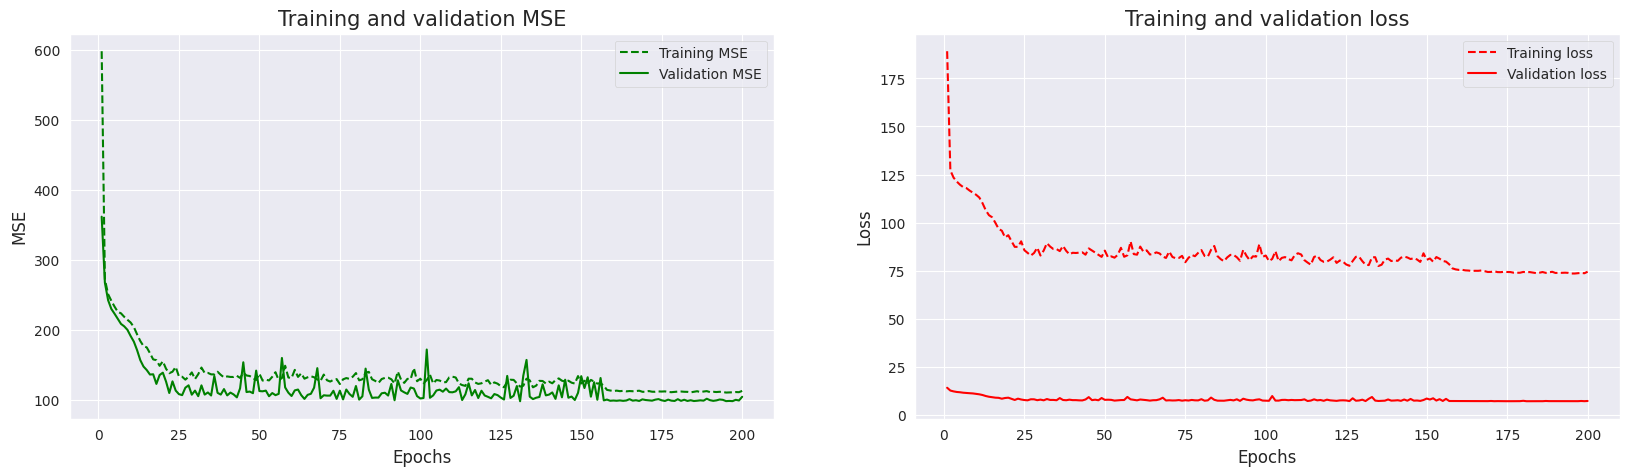

In [14]:
plot_learning_curves(best_rnn_history.history)

MAE: 10.198884758364311
MSE: 185.03903345724908
Spearman's Correlation: 0.6613959460601707
R Squared: 0.4372982978820801


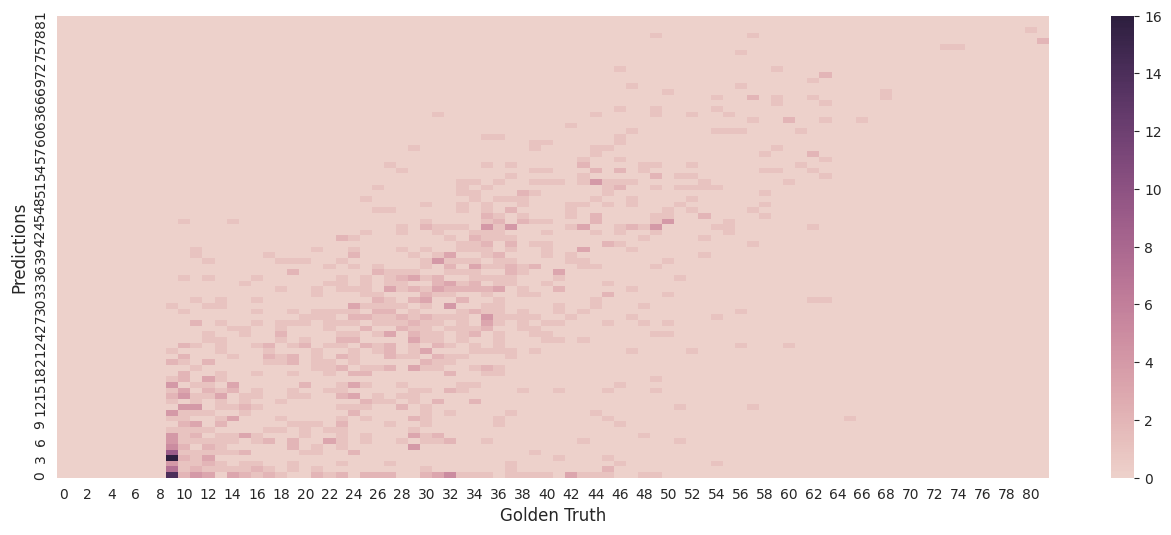

In [15]:
best_rnn2_model.load_weights("rnn2_model.h5")
rnn_mae, rnn_mse, rnn_sp, rnn_r2 = report(best_rnn2_model, X_views_test)

In [12]:
best_rnn2_model.load_weights("rnn2_model.h5")
print(best_rnn2_model.evaluate(X_views_test, y_test)) #183

temp = pd.DataFrame(best_rnn2_model.predict(X_views_test).flatten().round(0).astype(int), index=X_audio_test.index)
true_ranks = y_test.argsort().argsort()
predicted_ranks = temp.iloc[:,0].argsort().argsort()

print(stats.spearmanr(true_ranks, predicted_ranks)) #0.66

34/34 [==============================] - 0s 8ms/step - loss: 9.3677 - mse: 179.2548 - mae: 10.0361
[9.367745399475098, 179.2548065185547, 10.036117553710938]
34/34 [==============================] - 2s 8ms/step
SpearmanrResult(correlation=0.6673490356414475, pvalue=1.2522866715662577e-139)


## Final Model

In [18]:
def rnn_model(n_layers=6, n_timesteps = 41, n_features = 2):
    
    mel_input = Input(shape = (1292, 128), name="MEL_INPUT")
    audio_input = Input(shape= (X_audio_train.shape[1:]), name="AUDIO_INPUT")
    genres_input = Input(shape=(X_genres_train.shape[1:]), name="GENRES_INPUT")
    views_input = Input(shape=(n_timesteps, n_features), name="VIEWS_INPUT")
    
    #Spectrograms
    x = Conv1D(filters= 128, kernel_size= 11, padding='same', activation='relu')(mel_input)
    x = MaxPooling1D(pool_size=2)(x)
    x = BatchNormalization()(x)

    for i in range(n_layers - 1):
        x = Conv1D(32 * (2**i), kernel_size=11, strides=3 , padding='same', activation='relu')(x)
        x = MaxPooling1D(pool_size=4, padding='same')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.3)(x)

    x = GlobalAvgPool1D()(x)
    x = Dense(64, activation="selu", kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.2)(x)
    x = Dense(64, activation="selu", kernel_regularizer=l2(0.01))(x)
    mel_out = Dropout(0.3)(x)
    
    hidden_layer = Dense(256, activation = 'swish')(audio_input)
    hidden_layer = Dense(32, activation = 'swish')(hidden_layer)
    dropout = Dropout(0.4)(hidden_layer)
    hidden_layer = Dense(32, activation = 'swish')(dropout)
    dropout = Dropout(0.4)(hidden_layer)
    hidden_layer = Dense(32, activation = 'swish')(dropout)
    y = Dropout(0.4)(hidden_layer)
    
    hidden_layer = Dense(32, activation = 'swish')(genres_input)
    hidden_layer = Dense(176, activation = 'swish')(hidden_layer)
    dropout = Dropout(0.6)(hidden_layer)
    hidden_layer = Dense(32, activation = 'swish')(dropout)
    dropout = Dropout(0.6)(hidden_layer)
    hidden_layer = Dense(96, activation = 'selu')(dropout)
    dropout = Dropout(0.6)(hidden_layer)
    hidden_layer = Dense(256, activation = 'relu')(dropout)
    e = Dropout(0.6)(hidden_layer)
    
    audio_genres_out = Concatenate(axis=1, name="AUDIO_GENRE_OUTPUT")([y, e])
    
    #Views
    bi_gru = Bidirectional(GRU(32, return_sequences=True))(views_input)
    bi_gru = Bidirectional(GRU(32, return_sequences=True))(bi_gru)
    dropout = Dropout(0.1)(bi_gru)
    x = GlobalAvgPool1D()(dropout)
    flatten = Flatten()(x)

    x = Dense(128, activation='relu')(flatten)
    x = Dense(32, activation='elu')(x)
    dropout = Dropout(0.1)(x)
    x = Dense(32, activation='relu')(x)
    dropout = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    views_out = Dropout(0.1)(x)
    
    #Combined inputs are passed through a final MLP network
    combined = Concatenate(axis=1)([mel_out, audio_genres_out, views_out])

    out = Dense(1)(combined)

    model = Model(inputs=[mel_input, audio_input, genres_input, views_input], outputs=out)

    model.compile(optimizer=Adam(learning_rate=1e-4, beta_1=0.99, beta_2=0.999), loss="logcosh", metrics=["mse", "mae"])

    model.summary()

    return model

In [19]:
keras.backend.clear_session()
model = rnn_model()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 MEL_INPUT (InputLayer)         [(None, 1292, 128)]  0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 1292, 128)    180352      ['MEL_INPUT[0][0]']              
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 646, 128)     0           ['conv1d[0][0]']                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 646, 128)    512         ['max_pooling1d[0][0]']          
 alization)                                                                                   

 dropout_4 (Dropout)            (None, 1, 512)       0           ['batch_normalization_5[0][0]']  
                                                                                                  
 dropout_7 (Dropout)            (None, 32)           0           ['dense_3[0][0]']                
                                                                                                  
 dropout_11 (Dropout)           (None, 32)           0           ['dense_8[0][0]']                
                                                                                                  
 flatten (Flatten)              (None, 64)           0           ['global_average_pooling1d_1[0][0
                                                                 ]']                              
                                                                                                  
 global_average_pooling1d (Glob  (None, 512)         0           ['dropout_4[0][0]']              
 alAverage

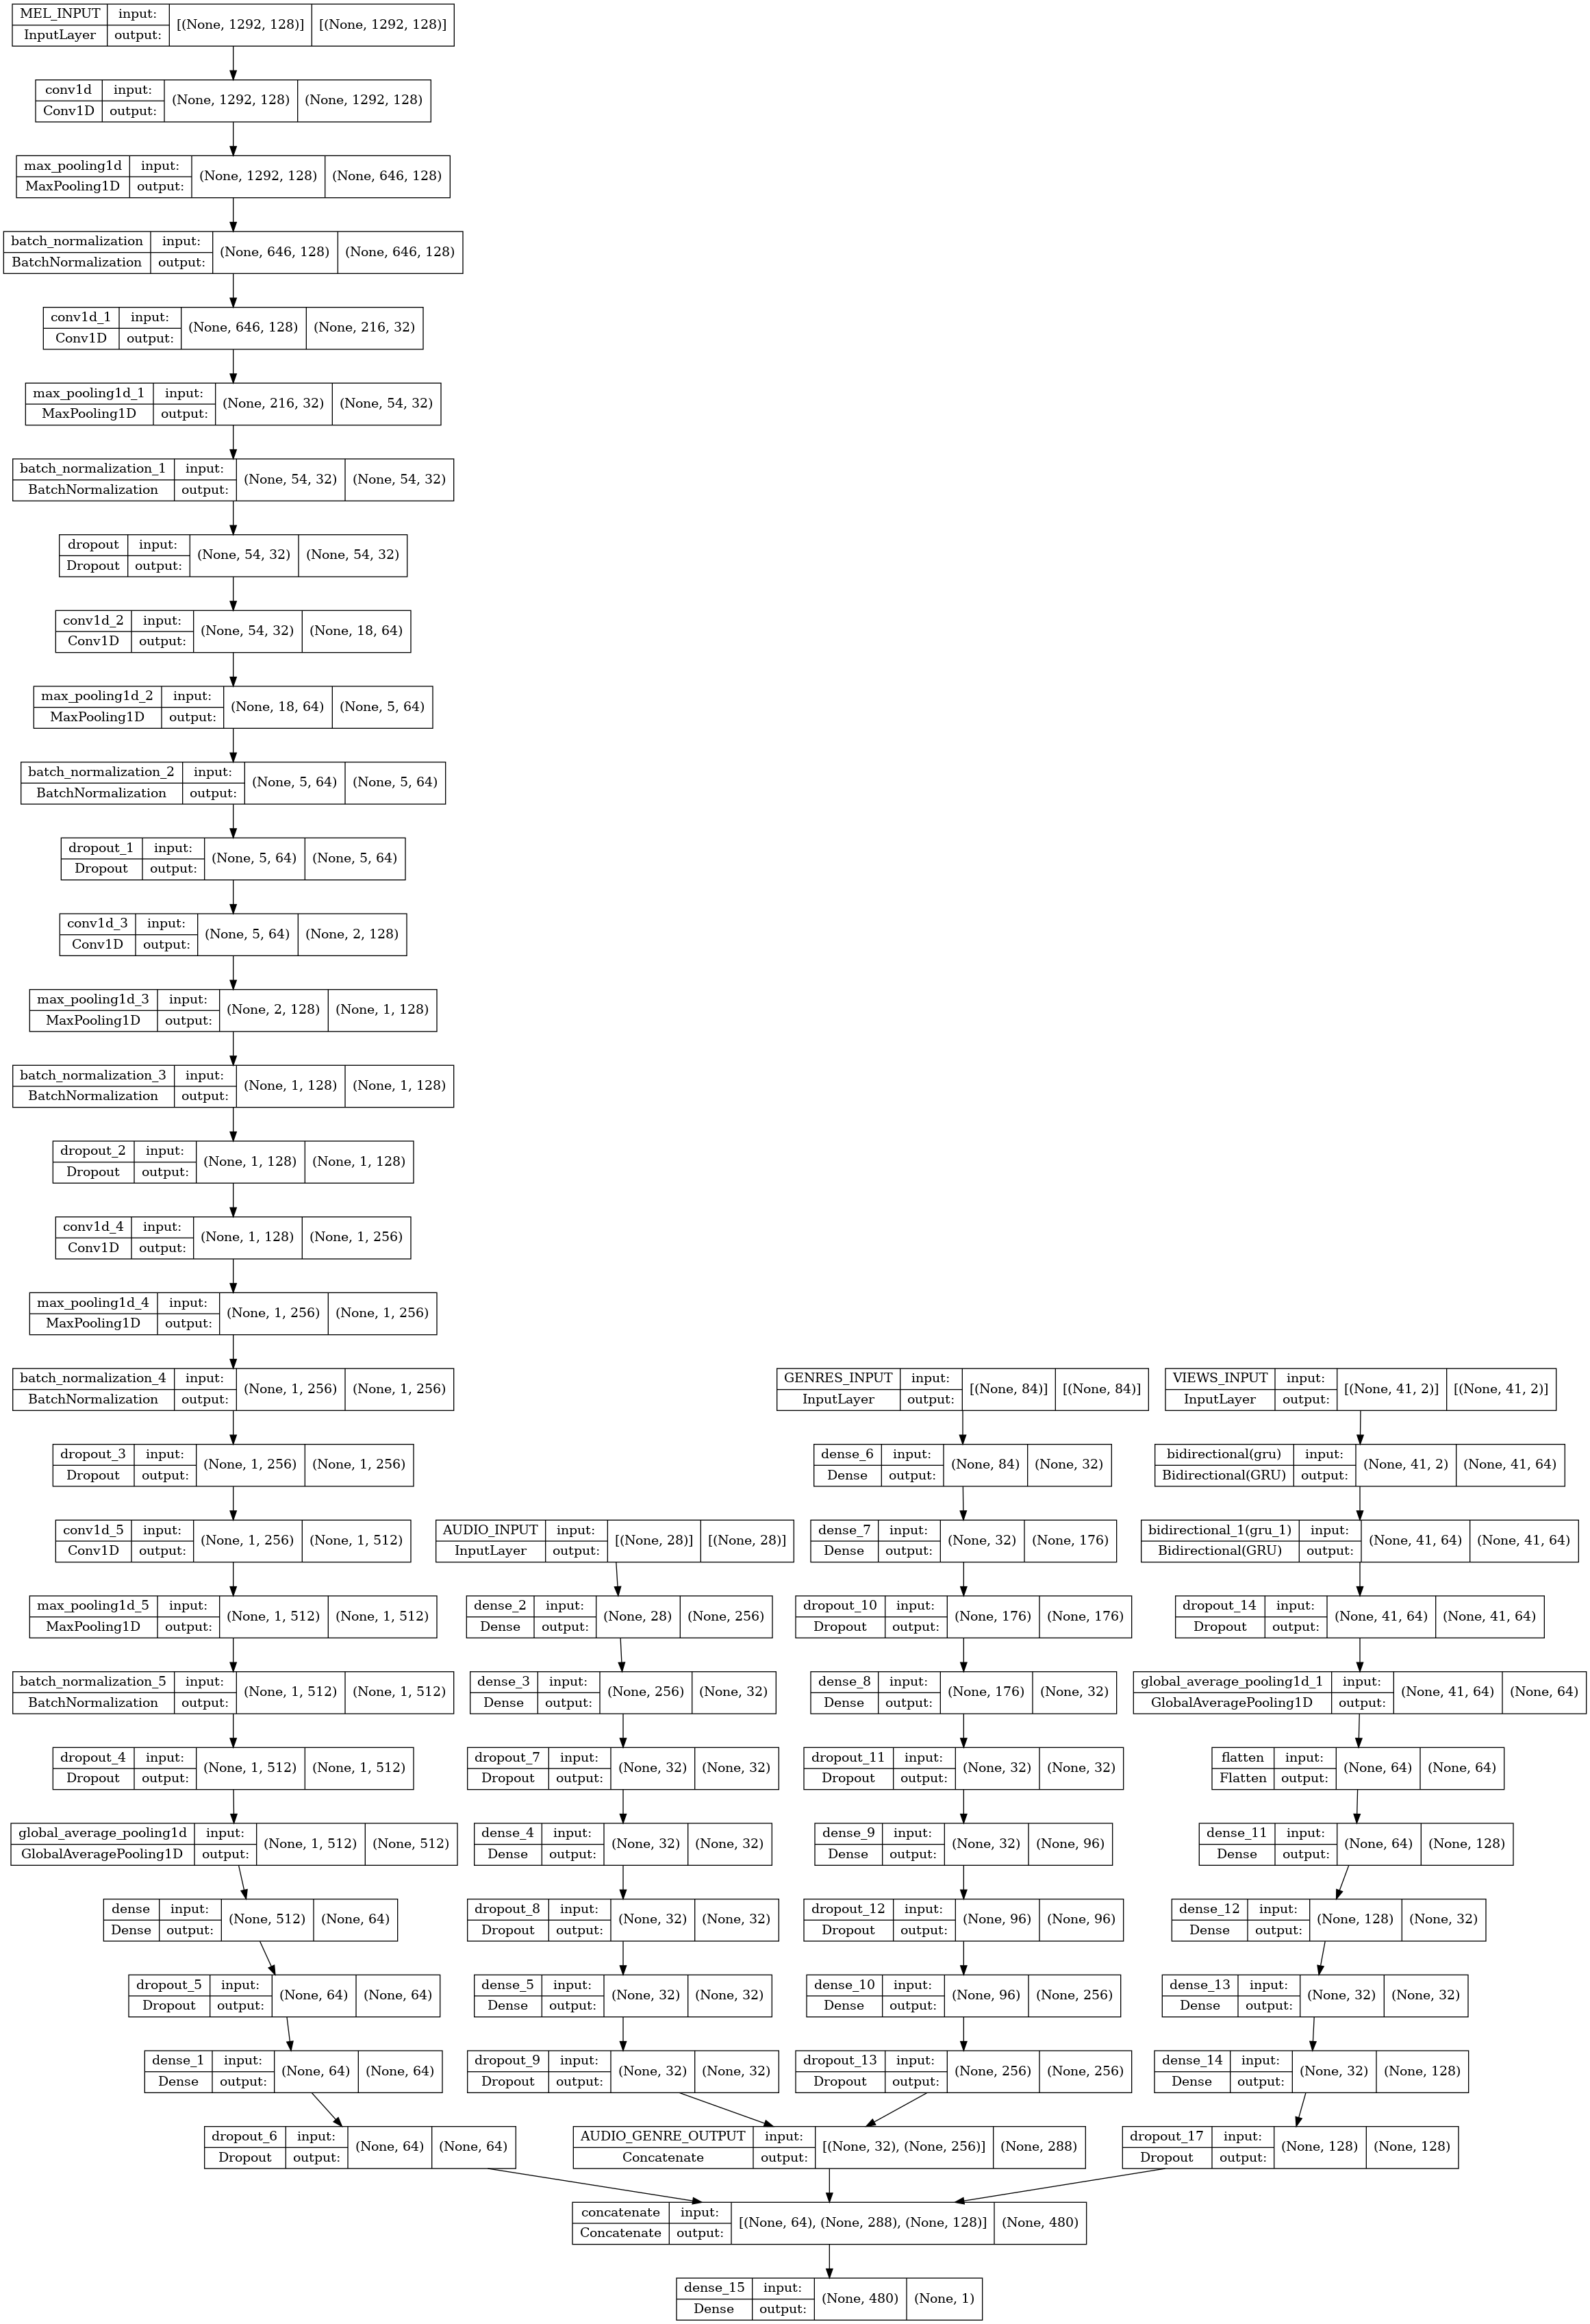

In [20]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [22]:
checkpoint = ModelCheckpoint(filepath='after_model.h5', monitor="val_mae", save_best_only=True)
reduce_o_p = ReduceLROnPlateau(monitor="val_mae", patience=15, min_lr=1e-7, mode="min")
earlystopper = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=30)

history = model.fit(
        [X_mel_train, X_audio_train, X_genres_train, X_views_train], y_train,
        sample_weight=sample_weight,
        validation_data=[[X_mel_val, X_audio_val, X_genres_val, X_views_val], y_val],
        batch_size=16,
        epochs=200,
        callbacks=[checkpoint, reduce_o_p, earlystopper],
    )

2022-11-15 19:32:24.553184: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 5689595904 exceeds 10% of free system memory.
2022-11-15 19:32:27.852767: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 5689595904 exceeds 10% of free system memory.


Epoch 1/200
538/538 [==============================] - 16s 19ms/step - loss: 183.6545 - mse: 555.1873 - mae: 18.8246 - val_loss: 14.9485 - val_mse: 303.4304 - val_mae: 13.8166 - lr: 1.0000e-04
Epoch 2/200
538/538 [==============================] - 8s 16ms/step - loss: 125.8471 - mse: 255.8093 - mae: 13.0542 - val_loss: 13.6597 - val_mse: 232.0800 - val_mae: 12.5407 - lr: 1.0000e-04
Epoch 3/200
538/538 [==============================] - 8s 16ms/step - loss: 120.7880 - mse: 235.2203 - mae: 12.5539 - val_loss: 13.2633 - val_mse: 215.1585 - val_mae: 12.1646 - lr: 1.0000e-04
Epoch 4/200
538/538 [==============================] - 9s 16ms/step - loss: 118.2736 - mse: 222.7974 - mae: 12.3072 - val_loss: 12.9052 - val_mse: 203.8509 - val_mae: 11.8269 - lr: 1.0000e-04
Epoch 5/200
538/538 [==============================] - 8s 16ms/step - loss: 114.3011 - mse: 209.4288 - mae: 11.9126 - val_loss: 12.3164 - val_mse: 184.3760 - val_mae: 11.2581 - lr: 1.0000e-04
Epoch 6/200
538/538 [==================

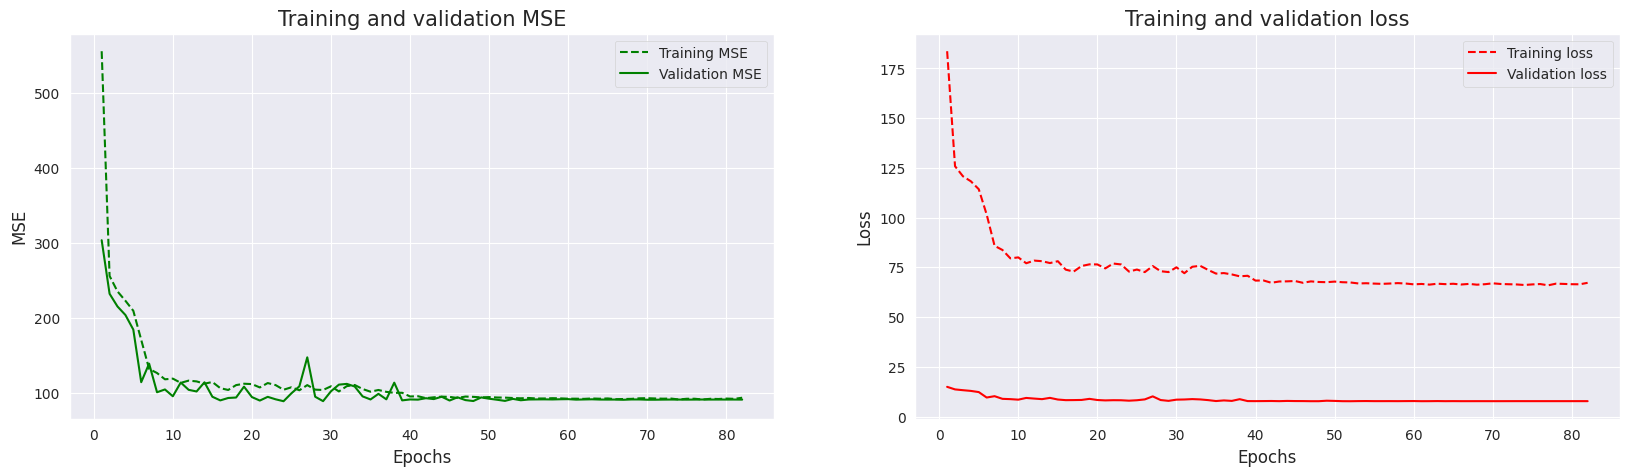

In [23]:
plot_learning_curves(history.history)

MAE: 9.25557620817844
MSE: 157.73327137546468
Spearman's Correlation: 0.7135423148121168
R Squared: 0.5203348398208618


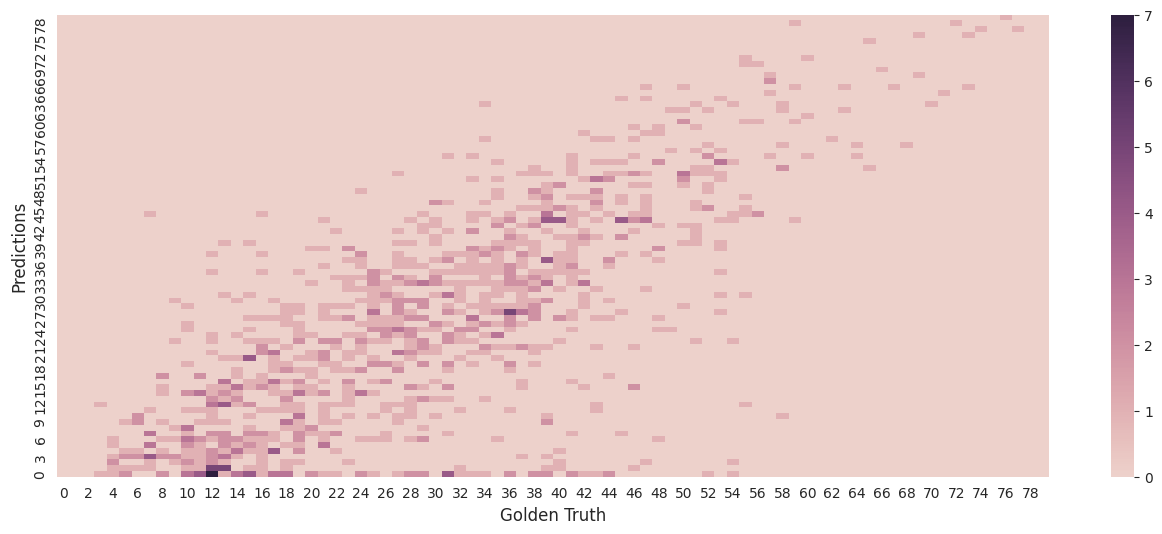

In [24]:
model.load_weights("after_model.h5")
mae, mse, sp, r2 = report(model, [X_mel_test, X_audio_test, X_genre_test, X_views_test])